In [1]:
## AOTLadderStats Analysis Script by LeoSixthNation, .csv data provided by RebelsRising through voobly.com

In [2]:
class matchfilter:
    def __init__(self, match_frame, player_frame, match_id = 'all', ladder = ['AOT_1X'], rating = 0, maps = 'NA', remove_maps = 'NA',  mod = 'NA', delta = 'NA', game_duration = 'all', names = 'all'):
        self.match_frame = match_frame
        self.player_frame = player_frame
        self.filter_dict = {}
        if(match_id != 'all'):
            self.filter_dict['match_id'] =  match_id
        self.filter_dict['ladder'] = ladder
        self.filter_dict['rating'] = rating
        if (maps != 'NA'):
            self.filter_dict['map'] = maps
        if (remove_maps != 'NA'):
            self.filter_dict['remove_maps'] = remove_maps
        if (mod != 'NA'):
            self.filter_dict['mod'] = mod
        if (delta != 'NA'):
            self.filter_dict['delta'] = delta
        if (game_duration != 'all'):
            self.filter_dict['game_duration'] = game_duration
        if (names != 'all'):
            self.filter_dict['names'] = names
            
    def apply_filter(self):
        for key, val in self.filter_dict.items():
            if key == 'match_id':
                mask = self.match_frame['match_id'].isin(val)
                self.match_frame = self.match_frame.loc[~mask]
            if key == 'ladder':
                mask = self.match_frame['ladder'].isin(val)
                self.match_frame = self.match_frame.loc[mask]
            if key == 'rating':
                self.match_frame = self.match_frame[self.match_frame['rating']>val]
            if key == 'mod':
                mask = self.match_frame['mod'].isin(val)
                self.match_frame = self.match_frame.loc[mask]
            if key == 'map':
                mask = self.match_frame['map'].isin(val)
                self.match_frame = self.match_frame.loc[mask]
            if key == 'remove_maps':
                mask = self.match_frame['map'].isin(val)
                self.match_frame = self.match_frame.loc[~mask]
                self.match_frame = self.match_frame[match_frame.applymap(type).eq(str)['map']]
            if key == 'delta':
                match_ids_temp = self.player_frame[abs(self.player_frame['delta']).isin(val)]['match_id']
                mask = self.match_frame['match_id'].isin(match_ids_temp)
                self.match_frame = self.match_frame.loc[~mask]
            if key == 'names':
                match_ids_temp = self.player_frame[self.player_frame['name'].isin(val)]['match_id']
                mask = self.match_frame['match_id'].isin(match_ids_temp)
                self.match_frame = self.match_frame.loc[~mask]
            if key == 'game_duration':
                self.match_frame = self.match_frame[self.match_frame['game_duration'] > val]
                
        #Synchronize the Player Frame after Match Frame has been filtered
        filtered_match_ids = self.match_frame['match_id']
        mask = self.player_frame['match_id'].isin(filtered_match_ids)
        self.player_frame = self.player_frame.loc[mask]
        

In [3]:
def preprocessing(match_frame, player_frame, match_id = 'all', ladder = ['AOT_1X'], rating = 0, maps = 'NA', remove_maps = 'NA', mod = 'NA', delta = 'NA', game_duration = 'all', names = 'all'):
    match_filter_prep = matchfilter(match_frame, player_frame,rating = rating, mod = mod, delta = delta, game_duration = game_duration, maps = maps, remove_maps = remove_maps, names = names)
    match_filter_prep.apply_filter()
    return match_filter_prep.match_frame, match_filter_prep.player_frame;

In [4]:
def get_win_usage_dictionary(match_frame, player_frame):
    god_list = player_frame['civ'].unique().tolist()
    god_dict = dict.fromkeys(god_list)
    total_rows = player_frame.shape[0]
    
    for key in god_dict.keys():
        god_dict[key] = []
        num_picks = len(player_frame[player_frame['civ']==key].index)
        
        #Usage Percentage
        god_dict[key].append(num_picks/(total_rows+1e-10) * 100)
        god_frametemp = player_frame[player_frame['civ']==key]
        nums_pick = god_frametemp.shape[0]
        
        #Removing all rows, for which match_id is not unique, i.e. removing mirror match-ups
        god_frametemp_nomirror = god_frametemp[god_frametemp.groupby('match_id').player_id.transform(len) < 2]
        #Win Percentage
        god_dict[key].append(np.count_nonzero(god_frametemp_nomirror['delta'] > 0 )/ (god_frametemp_nomirror.shape[0]+1e-10) * 100)
        
    return god_dict;

In [5]:
def plot_win_usage_map(god_dict, mapstring):
    df = pd.DataFrame(god_dict, index = ['usage', 'win'])
    df = df.T

    df = df.sort_values(by=['win'], axis=0, ascending=False)
    fig = plt.figure(figsize=(25,6)) # Create matplotlib figure

    ax = fig.add_subplot(111) # Create matplotlib axes

    width = 0.2

    p1 = df.plot(kind='bar', secondary_y = 'win', rot = 0, ax = ax)

    ax.right_ax.yaxis.grid(True, color = 'black', linestyle = '--')
    ax.right_ax.set_ylim([0, 80])
    ax.right_ax.set_yticks(np.linspace(0, 80, num = 9))
    ax.set_ylim([0, 18])
    #ax.yaxis.grid(True, color = 'grey', linestyle = 'dotted', linewidth = 1.0)

    ax.set_ylabel('Usage Percentage [%]')
    ax.right_ax.set_ylabel('Win Percentage [%]')
    plt.title(mapstring + ':' + ' Win Percentage + Usage Percentage')
    plt.savefig('win_usage_vbp' + mapstring + '.jpeg')
    #plt.legend(loc = 'upper right')
    plt.show()

    

In [6]:
def plot_win_usage(god_dict, patch):
    df = pd.DataFrame(god_dict, index = ['usage', 'win'])
    df = df.T

    df = df.sort_values(by=['win'], axis=0, ascending=False)
    fig = plt.figure(figsize=(25,6)) # Create matplotlib figure

    ax = fig.add_subplot(111) # Create matplotlib axes

    width = 0.2

    p1 = df.plot(kind='bar', secondary_y = 'win', rot = 0, ax = ax)

    ax.right_ax.yaxis.grid(True, color = 'black', linestyle = '--')
    ax.right_ax.set_ylim([0, 80])
    ax.right_ax.set_yticks(np.linspace(0, 80, num = 9))
    ax.set_ylim([0, 18])
    #ax.yaxis.grid(True, color = 'grey', linestyle = 'dotted', linewidth = 1.0)

    ax.set_ylabel('Usage Percentage [%]')
    ax.right_ax.set_ylabel('Win Percentage [%]')
    if(patch == 'VBP4.0'):
        plt.title('VBP4.0: Win Percentage + Usage Percentage')
        plt.savefig('win_usage_vbp4.jpeg')
    elif(patch == 'VBP5.0'):
        plt.title('VBP5.0: Win Percentage + Usage Percentage')
        plt.savefig('win_usage_vbp5.jpeg')
    #plt.legend(loc = 'upper right')
    plt.show()

    

In [7]:
def get_matchup_matrix_dictionary(match_frame, player_frame):
    god_list = player_frame['civ'].unique().tolist()
    god_list = sorted(god_list)
    god_dict = dict.fromkeys(god_list)
    total_rows = player_frame.shape[0]
    #print(total_rows)
    
    for key in god_dict.keys():
        god_dict[key] = []
    
    god_matrix_dict = dict.fromkeys(god_list)
    for i in god_list:
        god_matrix_dict[i] = {key:[] for key in god_list}
        
        
    for (god, god_dict_row) in god_matrix_dict.items():
        god_frametemp = player_frame[player_frame['civ']==god]
        mask = player_frame['match_id'].isin(god_frametemp['match_id'].unique().tolist())
        god_frametemp = player_frame.loc[mask]
        #print("number of games played with" + " " + god + ' = ' + str(god_frametemp.shape[0]/2))
        for (god_row, win_tot) in god_dict_row.items():
            god_framematchup = god_frametemp[god_frametemp['civ']==god_row]
            if(god_row == god):
                win_tot.append(god_framematchup[god_framematchup.groupby('match_id').player_id.transform(len) == 2].shape[0]/2)
                win_tot.append(float('nan'))
            elif (god_framematchup.shape[0] == 0):
                win_tot.append(float('nan'))
                win_tot.append(float('nan'))
            else:
                win_tot.append(god_framematchup.shape[0])
                win_tot.append(np.count_nonzero(god_framematchup['delta'] < 0 ))
        #print(god_dict_row)
        
    #print(god_matrix_dict)
    return god_matrix_dict;
        

In [8]:
def get_win_perc(list_x):
    if(list_x[0] == 0):
        return(float('nan'))
    return list_x[1]/list_x[0]*100;

In [9]:
def get_game_number(list_x):
    return list_x[0];

In [10]:
def subtract(list_x):
    return list_x[0] - list_x[1];

In [11]:
def plot_matchup_matrix_dictionary(god_matrix_dict, patch):
    df = pd.DataFrame(god_matrix_dict, index=god_matrix_dict.keys())
    df_new = df.applymap(get_win_perc)
    df_number = df.applymap(get_game_number)
    #print(df_new.head)
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(25,18))

    #ax = fig.add_subplot(111)

    #ax.set_aspect(1)

    #res = sn.heatmap(df.T, annot=True, fmt='.2f', cmap="YlGnBu", cbar=False)
    #sn.set(font_scale=2.8)
    g = sn.heatmap(df_new.T, annot=True, fmt='.2f', cmap="YlGnBu", cbar=False, ax = ax1,  annot_kws={"fontsize":25})
    #g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 25)


    #ax = fig.add_subplot(111)

    #ax.set_aspect(1)

    #res = sn.heatmap(df.T, annot=True, fmt='.2f', cmap="YlGnBu", cbar=False)
    
    sn.heatmap(df_number.T, annot=True, fmt='.0f', cmap="YlOrBr", cbar=False, ax = ax2, annot_kws={"fontsize":25})
    
    if(patch == 'VBP4.0'):
        ax1.set_title('VBP4.0: Matchup Matrix: Wins [%]')
        ax2.set_title('VBP4.0: Matchup Matrix: Games Played')
        plt.savefig('matchup_matrix_vbp4.jpeg')
    elif(patch == 'VBP5.0'):
        ax1.set_title('VBP5.0: Matchup Matrix: Wins [%]')
        ax2.set_title('VBP5.0: Matchup Matrix: Games Played')
        plt.savefig('matchup_matrix_vbp5.jpeg')
    plt.show()

In [12]:
def get_plot_win_usage_perc_maps(match_frame, player_frame, names = 'all', rating = 1700,  delta = [1, 40, 39, 38], logfile=None):
    maps_played = [['Alfheim 5-0-0','alfheim 5-0-0'], ['Blue Lagoon 5-0-0', 'blue lagoon 5-0-0'] ,
                   ['Frozen Wastes 5-0-0', 'frozen wastes 5-0-0'], ['Painted Desert 5-0-0','painted desert 5-0-0'],
                   ['Tundra 5-0-0','tundra 5-0-0'], ['Marsh 5-0-0','marsh 5-0-0'],
                   ['Ghost Lake 5-0-0','ghost lake 5-0-0'], ['Savannah 5-0-0','savannah 5-0-0'],
                   ['Oasis 5-0-0','oasis 5-0-0'], ['Mediterranean 5-0-0','mediterranean 5-0-0'],
                   ['Watering Hole 5-0-0', 'watering hole 5-0-0'], ['Midgard 5-0-0','midgard 5-0-0'],
                   ['Anatolia 5-0-0', 'anatolia 5-0-0'], ['Water Maps', 'Anatolia 5-0-0', 'anatolia 5-0-0', 
                   'Midgard 5-0-0','midgard 5-0-0', 'Mediterranean 5-0-0','mediterranean 5-0-0' ], ['Land Maps', 'Alfheim 5-0-0','alfheim 5-0-0',
                    'Blue Lagoon 5-0-0', 'blue lagoon 5-0-0', 'Frozen Wastes 5-0-0', 'frozen wastes 5-0-0',
                    'Painted Desert 5-0-0','painted desert 5-0-0', 'Tundra 5-0-0','tundra 5-0-0', 
                    'Marsh 5-0-0','marsh 5-0-0', 'Ghost Lake 5-0-0','ghost lake 5-0-0', 'Savannah 5-0-0','savannah 5-0-0',
                    'Oasis 5-0-0','oasis 5-0-0', 'Watering Hole 5-0-0', 'watering hole 5-0-0']]
    for map_list in maps_played:
        df, dfp = preprocessing(match_frame, player_frame, rating = rating, mod = ['Voobly Balance Patch 5.0 Blind', 'Voobly Balance Patch 5.0'], delta = delta, game_duration = 0, maps = map_list, names = names)
        #print(df['map'].value_counts())
        god_dict = get_win_usage_dictionary(df, dfp)
        print(god_dict)
        plot_win_usage_map(god_dict, map_list[0])
        
        dfm = pd.DataFrame(god_dict, index = ['usage', 'win'])
        dfm.T.to_csv('usage_win_vbp5' + map_list[0], sep = '\t', index = True)
        

In [13]:
def compare_vbp4_vbp5_win_usage(match_frame, player_frame, game_duration = 0, names = 'all', rating = 1700, delta = [1, 40, 39, 38], logfile = None):
    god_list = player_frame['civ'].unique().tolist()
    #god_list = ['RA', 'ISIS', 'SET']
    god_dict_usage = dict.fromkeys(god_list)
    god_dict_win   = dict.fromkeys(god_list)
    
    df5, dfp5 = preprocessing(match_frame, player_frame, rating = rating, mod = ['Voobly Balance Patch 5.0 Blind', 'Voobly Balance Patch 5.0'], delta = delta, game_duration = game_duration, names = names)
    total_rows5 = dfp5.shape[0]
    
    for key in god_dict_usage.keys():
        god_dict_usage[key] = []
        god_dict_win[key]   = []
        num_picks = len(dfp5[dfp5['civ']==key].index)
        
        #Usage Percentage
        god_dict_usage[key].append(num_picks/(total_rows5+1e-10) * 100)
        god_frametemp = dfp5[dfp5['civ']==key]
        nums_pick = god_frametemp.shape[0]
        
        #Removing all rows, for which match_id is not unique, i.e. removing mirror match-ups
        god_frametemp_nomirror = god_frametemp[god_frametemp.groupby('match_id').player_id.transform(len) < 2]
        #Win Percentage
        god_dict_win[key].append(np.count_nonzero(god_frametemp_nomirror['delta'] > 0 )/ (god_frametemp_nomirror.shape[0]+1e-10) * 100)
        
    df4, dfp4 = preprocessing(match_frame, player_frame, rating = rating, mod = ['Voobly Balance Patch 4.0 Blind', 'Voobly Balance Patch 4.0'], delta = delta, game_duration = game_duration, names = names)
    total_rows4 = dfp4.shape[0]
    
    for key in god_dict_usage.keys():
        num_picks = len(dfp4[dfp4['civ']==key].index)
        
        #Usage Percentage
        god_dict_usage[key].append(num_picks/(total_rows4+1e-10) * 100)
        god_frametemp = dfp4[dfp4['civ']==key]
        nums_pick = god_frametemp.shape[0]
        
        #Removing all rows, for which match_id is not unique, i.e. removing mirror match-ups
        god_frametemp_nomirror = god_frametemp[god_frametemp.groupby('match_id').player_id.transform(len) < 2]
        #Win Percentage
        god_dict_win[key].append(np.count_nonzero(god_frametemp_nomirror['delta'] > 0 )/ (god_frametemp_nomirror.shape[0]+1e-10) * 100)
        
    plot_vbp4_vbp5_barcharts(god_dict_usage, god_dict_win, logfile)
    
    dfu = pd.DataFrame(god_dict_usage, index = ['vbp5.0', 'vbp4.0'])
    dfu.T.to_csv('usage_compare_vbp4_vbp5' + str(rating), sep = '\t', index = True)
    
    dfw = pd.DataFrame(god_dict_win, index = ['vbp5.0', 'vbp4.0'])
    dfw.T.to_csv('usage_compare_vbp4_vbp5' + str(rating), sep = '\t', index = True)


In [14]:
def plot_vbp4_vbp5_barcharts(god_dict_usage, god_dict_win, logfile=None):
    dfu = pd.DataFrame(god_dict_usage, index = ['vbp5.0', 'vbp4.0'])
    dfu = dfu.T
    
    dfw = pd.DataFrame(god_dict_win, index = ['vbp5.0', 'vbp4.0'])
    dfw = dfw.T

    dfu = dfu.sort_values(by=['vbp5.0'], axis=0, ascending=False)
    dfw = dfw.sort_values(by=['vbp5.0'], axis=0, ascending=False)
    
    
    fig = plt.figure(figsize=(25,6)) # Create matplotlib figure

    ax = fig.add_subplot(111) # Create matplotlib axes

    width = 0.2

    p1 = dfu.plot(kind='bar',  rot = 0, ax = ax, color = {'vbp5.0' : '#80003A' , 'vbp4.0' : '#FFA400'})

    ax.yaxis.grid(True, color = 'black', linestyle = '--')
    #ax.right_ax.set_ylim([0, 80])
    #ax.right_ax.set_yticks(np.linspace(0, 80, num = 9))
    ax.set_ylim([0, 18])
    #ax.yaxis.grid(True, color = 'grey', linestyle = 'dotted', linewidth = 1.0)

    ax.set_ylabel('Usage Percentage [%]')
    #ax.right_ax.set_ylabel('Win Percentage [%]')
    plt.title('Usage Percentage: VBP4.0 vs VBP5.0')
    plt.savefig('vbp4_vbp5_usage.jpeg')
    #plt.legend(loc = 'upper right')
    plt.show()
    
    
    fig = plt.figure(figsize=(25,6)) # Create matplotlib figure

    ax = fig.add_subplot(111) # Create matplotlib axes

    width = 0.2

    p1 = dfw.plot(kind='bar',  rot = 0, ax = ax, color = {'vbp5.0' : '#80003A' , 'vbp4.0' : '#FFA400'})

    ax.yaxis.grid(True, color = 'black', linestyle = '--')
    #ax.right_ax.set_ylim([0, 80])
    ax.set_yticks(np.linspace(30, 70, num = 9))
    ax.set_ylim([30, 70])
    #ax.yaxis.grid(True, color = 'grey', linestyle = 'dotted', linewidth = 1.0)

    ax.set_ylabel('Win Percentage [%]')
    #ax.right_ax.set_ylabel('Win Percentage [%]')
    plt.title('Win Percentage: VBP4.0 vs VBP5.0')
    plt.savefig('vbp4_vbp5_win.jpeg')
    #plt.legend(loc = 'upper right')
    plt.show()
    
    logfile.write("Standard Deviation of usage:\n")
    logfile.write(str(dfu.std(axis = 0, ddof = 0)) + "\n")
    print("Standard Deviation of usage:")
    print(dfu.std(axis = 0, ddof = 0))
    
    logfile.write("Standard Deviation of win percentages:\n")
    logfile.write(str(dfw.std(axis = 0, ddof = 0)) + "\n")
    print("Standard Deviation of win percentages:")
    print(dfw.std(axis = 0, ddof = 0))
    
    dfu['Difference'] = dfu['vbp5.0'] - dfu['vbp4.0']
    print('Differences in usage:')
    logfile.write('Differences in usage:\n')
    dfud = dfu.sort_values(by=['Difference'], axis=0, ascending=True)
    logfile.write(repr(dfud['Difference'].index) + "\n")
    logfile.write(repr(dfud['Difference'].values) + "\n")
    print(dfud['Difference'].index)
    print(dfud['Difference'].values)
    
    
    dfw['Difference'] = dfw['vbp5.0'] - dfw['vbp4.0']
    print('Differences in win:')
    logfile.write('Differences in win:\n')
    dfwd = dfw.sort_values(by=['Difference'], axis=0, ascending=True)
    logfile.write(repr(dfwd['Difference'].index) + "\n")
    logfile.write(repr(dfwd['Difference'].values) + "\n")
    print(dfwd['Difference'].index)
    print(dfwd['Difference'].values)
    

In [15]:
def ladderstat_analysis_vbp4_vbp5(match_frame, player_frame, rating = 1700, delta = [1, 40, 39, 38], game_duration = 0, names = 'all', logfile=None):
    #Win-Usage Statistics
    #VBP4.0
    df4, dfp4 = preprocessing(match_frame, player_frame, rating = rating, mod = ['Voobly Balance Patch 4.0 Blind', 'Voobly Balance Patch 4.0'], delta = delta, game_duration = game_duration, names = names)
    logfile.write("VBP4.0 Total Games after filtering:\n")
    logfile.write(repr(df4.shape) + '\n')              
    print("VBP4.0 Total Games after filtering:")
    print(df4.shape)
    #print(dfp4.shape)
    print("VBP4.0 Total Games with available map information after filtering:")
    print(np.count_nonzero(df4.applymap(type).eq(str)['map']))
    logfile.write("VBP4.0 Total Games with available map information after filtering:\n")
    logfile.write(repr(np.count_nonzero(df4.applymap(type).eq(str)['map'])) + "\n")  
    
    df5, dfp5 = preprocessing(match_frame, player_frame, rating = rating, mod = ['Voobly Balance Patch 5.0 Blind', 'Voobly Balance Patch 5.0'], delta = delta, game_duration = game_duration, names = names)
    print("VBP5.0 Total Games after filtering:")
    print(df5.shape)
    logfile.write("VBP5.0 Total Games after filtering:\n")
    logfile.write(repr(df5.shape) + '\n')  
    #print(dfp4.shape)
    print("VBP5.0 Total Games with available map information after filtering:")
    print(np.count_nonzero(df5.applymap(type).eq(str)['map']))
    logfile.write("VBP5.0 Total Games with available map information after filtering:\n")
    logfile.write(repr(np.count_nonzero(df5.applymap(type).eq(str)['map']))+ "\n")  
    
    god_dict4 = get_win_usage_dictionary(df4, dfp4)
    god_dict5 = get_win_usage_dictionary(df5, dfp5)
    
    plot_win_usage(god_dict4, 'VBP4.0')
    plot_win_usage(god_dict5, 'VBP5.0')
    
    god_matrix_dict4 = get_matchup_matrix_dictionary(df4,dfp4)
    god_matrix_dict5 = get_matchup_matrix_dictionary(df5,dfp5)
    
    plot_matchup_matrix_dictionary(god_matrix_dict4, 'VBP4.0')
    plot_matchup_matrix_dictionary(god_matrix_dict5, 'VBP5.0')
    
    dfma4 = pd.DataFrame(god_matrix_dict4, index=god_matrix_dict4.keys())
    dfma4_new = dfma4.applymap(get_win_perc)
    dfma4_number = dfma4.applymap(get_game_number)
    dfma4_new.to_csv('win_matrix_vbp4_' + str(rating), sep = '\t', index = True)
    dfma4_number.to_csv('number_matrix_vbp4_' + str(rating), sep = '\t', index = True)
    
    dfma5 = pd.DataFrame(god_matrix_dict4, index=god_matrix_dict4.keys())
    dfma5_new = dfma5.applymap(get_win_perc)
    dfma5_number = dfma5.applymap(get_game_number)
    dfma5_new.to_csv('win_matrix_vbp5_' + str(rating), sep = '\t', index = True)
    dfma5_number.to_csv('number_matrix_vbp5_' + str(rating), sep = '\t', index = True)
    
    

In [16]:
%matplotlib inline
import os
from datetime import date
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib
import seaborn as sn

from matplotlib.ticker import(MultipleLocator, FormatStrFormatter, AutoMinorLocator, FuncFormatter)

from scipy.optimize import curve_fit

rc('font', **{'family':'sans-serif','sans-serif':['Helvetica'], 'size' : 20})
#matplotlib.rc('font', **font)

plt.rcParams.update({'font.size': 22, 'font.family':'sans-serif'})
rc('text', usetex=False)

In [17]:
path = os.getcwd()
print("The current working directory is %s" %path)

The current working directory is /home/leonard/Documents/AOT_LadderStats


In [18]:
match_frame = pd.read_csv('match.csv')
player_frame = pd.read_csv('player_data.csv')
print(match_frame.shape)
print(player_frame.shape)
print(np.count_nonzero(match_frame.applymap(type).eq(str)['map']))

(131898, 10)
(263796, 9)
31837


In [19]:
player_frame['name'].value_counts()[0:20]

zodiac_            3506
__Kimo             2785
ROMEOOO            2168
filatelico         2086
oelewapper         2069
VitorNascimento    1951
Lezuziusz007       1698
arkonts            1640
m4rcos_            1624
InspectorWadjet    1550
3antozz            1542
_Evil___           1409
giojeur            1349
Spamt              1336
Psycho_Paul        1334
Enk1_              1312
kikin_stereo       1309
Deef               1223
HUSKSUPPE          1195
ex0rb              1113
Name: name, dtype: int64

In [ ]:
['Ghost Lake 5-0-0','ghost lake 5-0-0']

02_10_2021
None
/home/leonard/Documents/AOT_LadderStats/Stats02_10_2021_1700


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


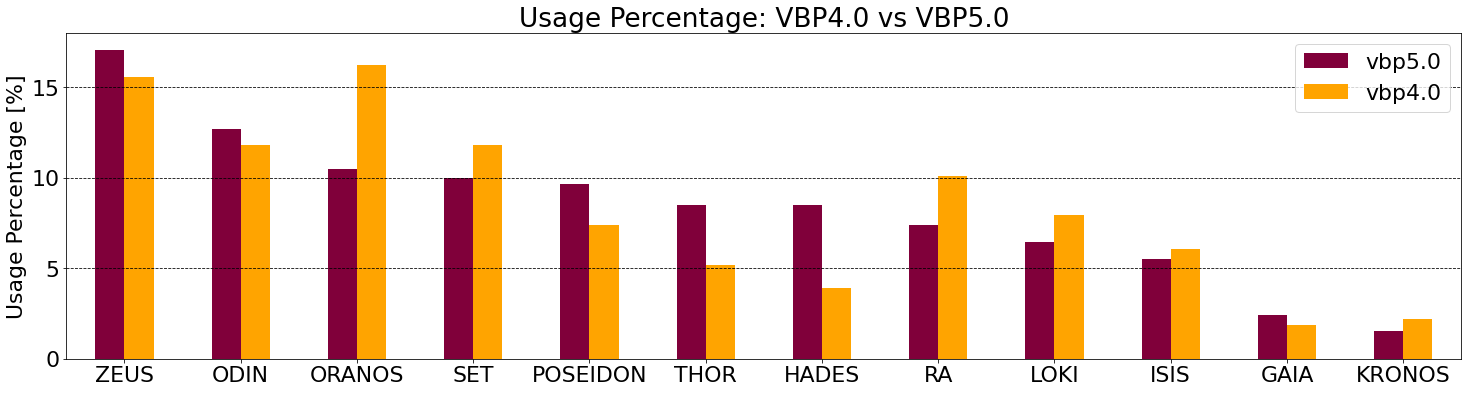

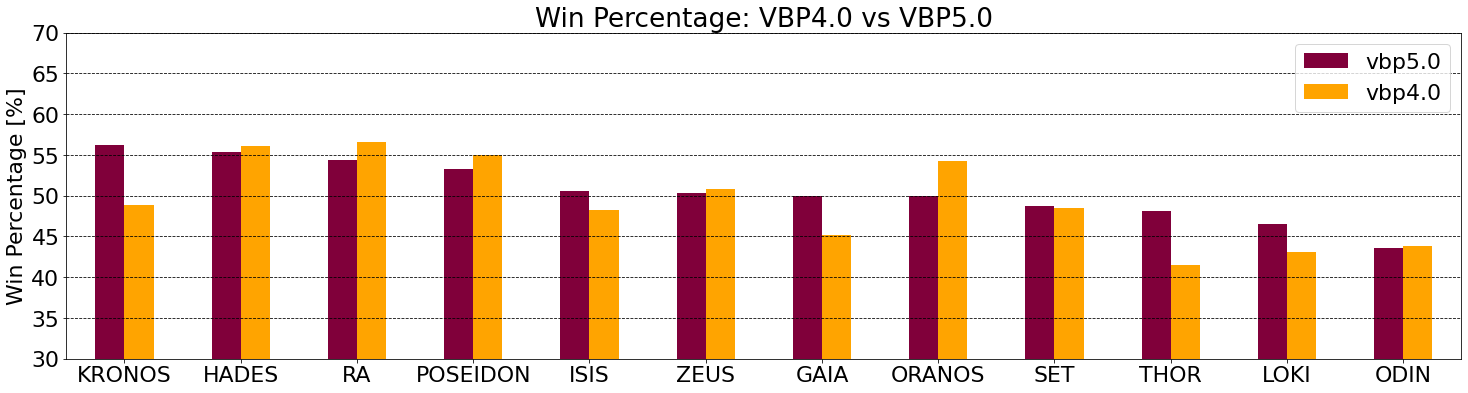

Standard Deviation of usage:
vbp5.0    4.054659
vbp4.0    4.634344
dtype: float64
Standard Deviation of win percentages:
vbp5.0    3.541575
vbp4.0    5.050170
dtype: float64
Differences in usage:
Index(['ORANOS', 'RA', 'SET', 'LOKI', 'KRONOS', 'ISIS', 'GAIA', 'ODIN', 'ZEUS',
       'POSEIDON', 'THOR', 'HADES'],
      dtype='object')
[-5.77371541 -2.71592672 -1.87175112 -1.52308757 -0.67617628 -0.54058298
  0.5761833   0.85377787  1.47298692  2.27360931  3.34354116  4.58114152]
Differences in win:
Index(['ORANOS', 'RA', 'POSEIDON', 'HADES', 'ZEUS', 'ODIN', 'SET', 'ISIS',
       'LOKI', 'GAIA', 'THOR', 'KRONOS'],
      dtype='object')
[-4.31939073 -2.23162913 -1.7611336  -0.75900079 -0.52850897 -0.25949227
  0.25997348  2.29694349  3.46503429  4.82233503  6.55047964  7.40667942]
{'RA': [6.855439642324377, 59.99999999993333], 'POSEIDON': [9.836065573769758, 60.48387096769316], 'ODIN': [13.561847988076487, 39.88095238092865], 'LOKI': [6.855439642324377, 37.49999999995738], 'ORANOS': [9.239

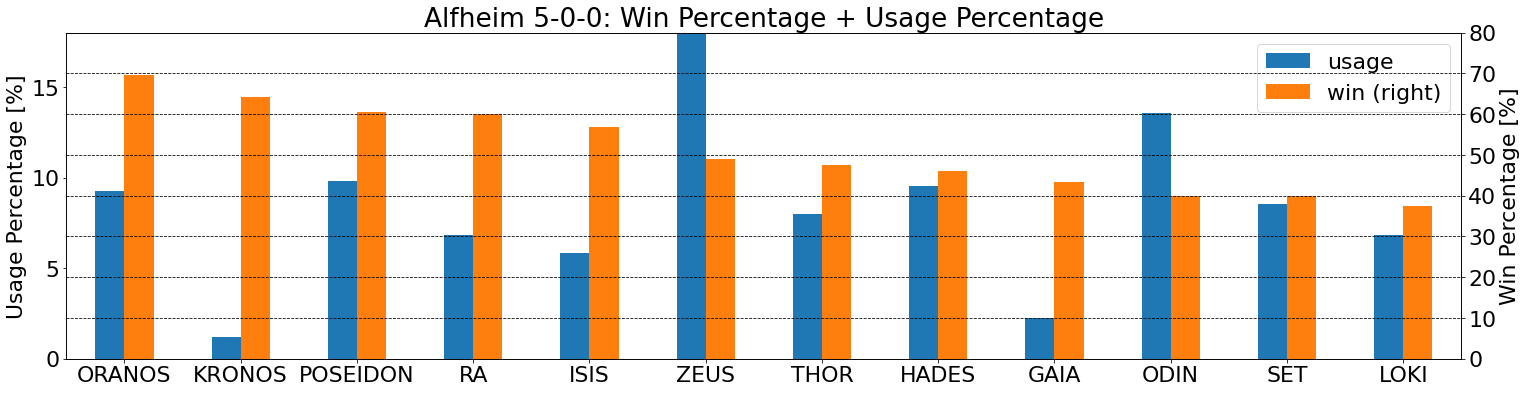

{'POSEIDON': [9.999999999999275, 60.31746031741244], 'ODIN': [12.753623188404873, 48.701298701267085], 'ORANOS': [10.072463768115211, 48.71794871790708], 'LOKI': [7.246376811593677, 35.55555555551605], 'THOR': [6.666666666666184, 47.72727272721849], 'KRONOS': [1.7391304347824827, 45.45454545433885], 'RA': [8.115942028984918, 55.357142857093436], 'ISIS': [6.666666666666184, 49.99999999994565], 'SET': [7.101449275361804, 48.913043478207705], 'HADES': [9.927536231883337, 57.89473684206173], 'ZEUS': [17.5362318840567, 48.19819819817649], 'GAIA': [2.173913043478103, 30.769230769112426]}


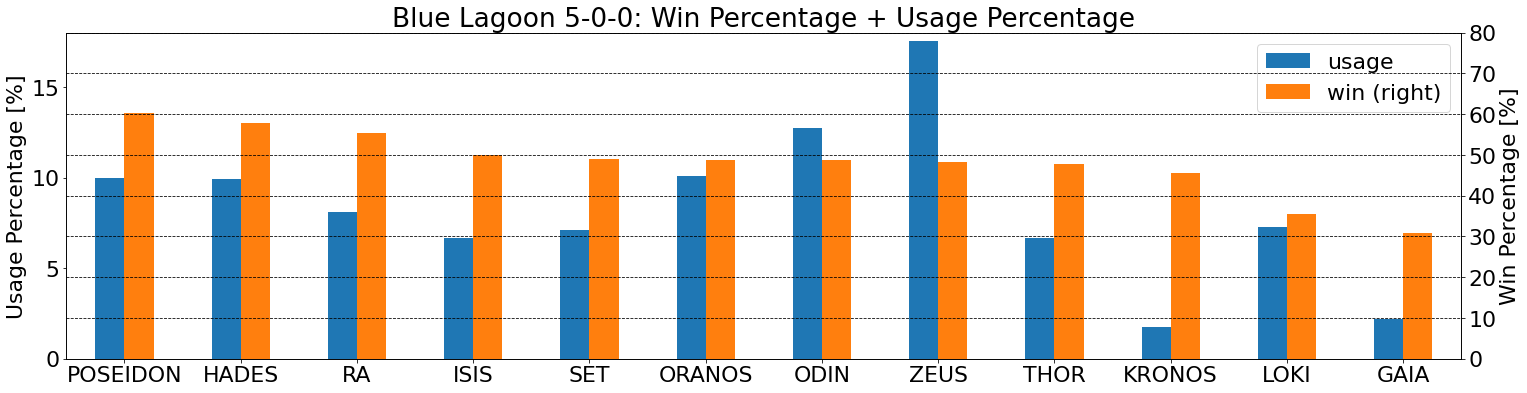

{'POSEIDON': [10.498489425981079, 55.905511810979604], 'ZEUS': [17.975830815708612, 39.5238095237907], 'ORANOS': [11.027190332325452, 61.1940298507006], 'SET': [7.628398791540208, 44.44444444439955], 'GAIA': [2.2658610271901614, 58.33333333309029], 'KRONOS': [1.812688821752129, 36.36363636347107], 'LOKI': [6.268882175226112, 49.333333333267554], 'ODIN': [12.31117824773321, 54.362416107346064], 'THOR': [5.966767371600758, 51.94805194798449], 'RA': [8.610271903322612, 41.8181818181438], 'ISIS': [5.7401812688817415, 47.142857142789794], 'HADES': [9.89425981873037, 57.59999999995392]}


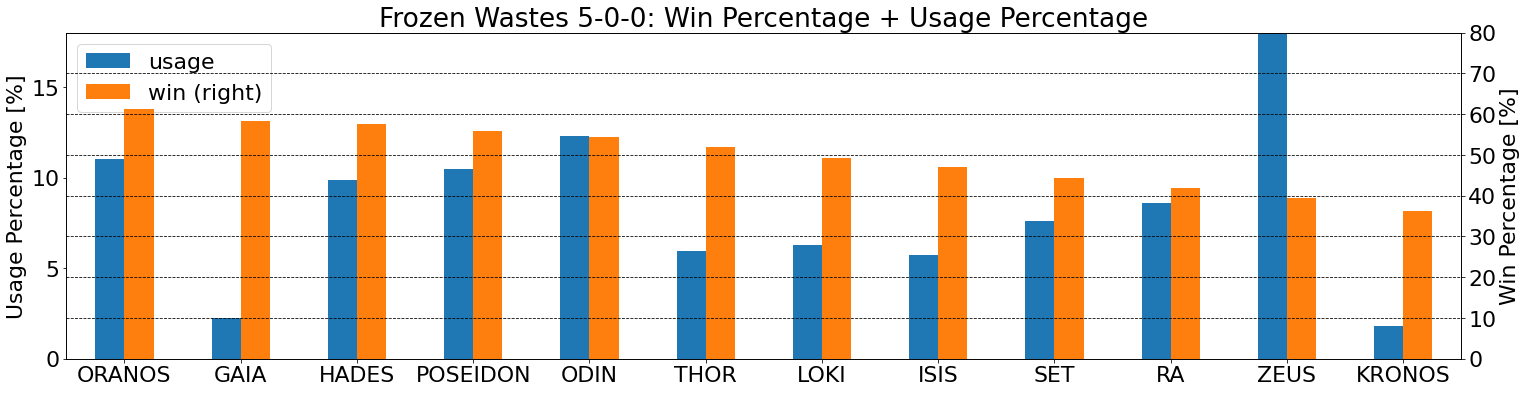

{'POSEIDON': [9.79462875197395, 49.999999999958334], 'SET': [8.76777251184765, 47.422680412322244], 'ODIN': [14.06003159557551, 40.62499999997461], 'HADES': [8.609794628751294, 48.62385321096456], 'LOKI': [5.055292259083329, 46.66666666658889], 'THOR': [7.977883096365879, 51.578947368366755], 'ZEUS': [18.24644549762889, 53.29949238575975], 'RA': [7.503949447076816, 60.91954022981504], 'KRONOS': [1.7377567140598942, 59.090909090640494], 'ORANOS': [11.37440758293749, 55.737704917987095], 'ISIS': [5.055292259083329, 43.103448275787756], 'GAIA': [1.8167456556080712, 43.478260869376186]}


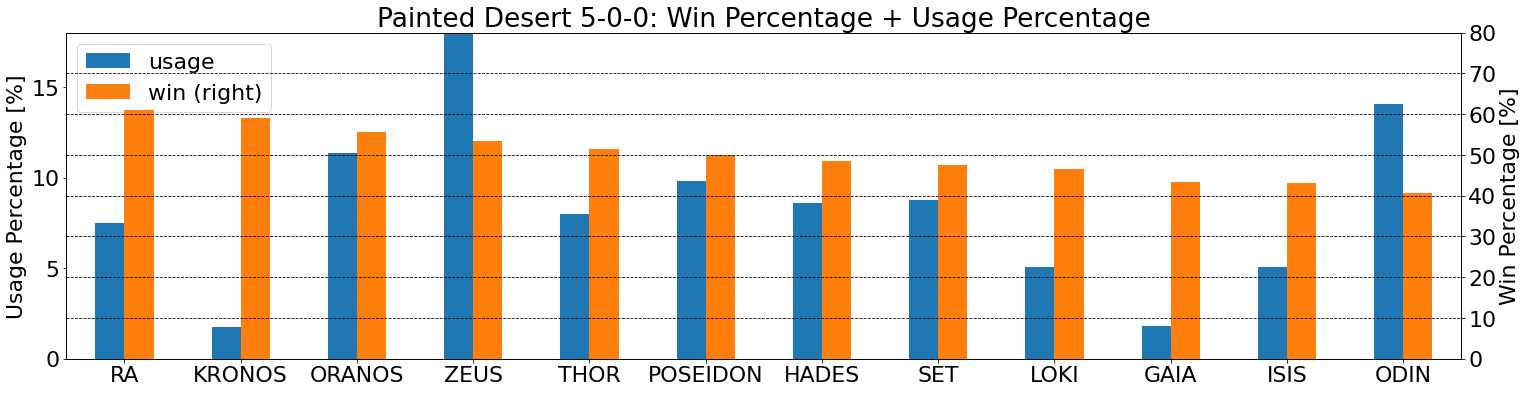

{'POSEIDON': [8.655332302935962, 52.72727272722479], 'ORANOS': [10.664605873260381, 45.38461538458048], 'RA': [7.496136012364181, 42.105263157850416], 'ODIN': [12.287480680060874, 58.50340136050443], 'HADES': [9.969088098917313, 53.04347826082344], 'GAIA': [2.1638330757339905, 49.9999999998077], 'LOKI': [7.0324574961354696, 55.55555555548697], 'SET': [9.041731066459887, 45.045045045004464], 'ZEUS': [18.933539412672413, 51.67464114830064], 'KRONOS': [1.5455950540957073, 61.11111111077161], 'THOR': [6.568778979906756, 42.168674698744375], 'ISIS': [5.641421947449333, 45.20547945199287]}


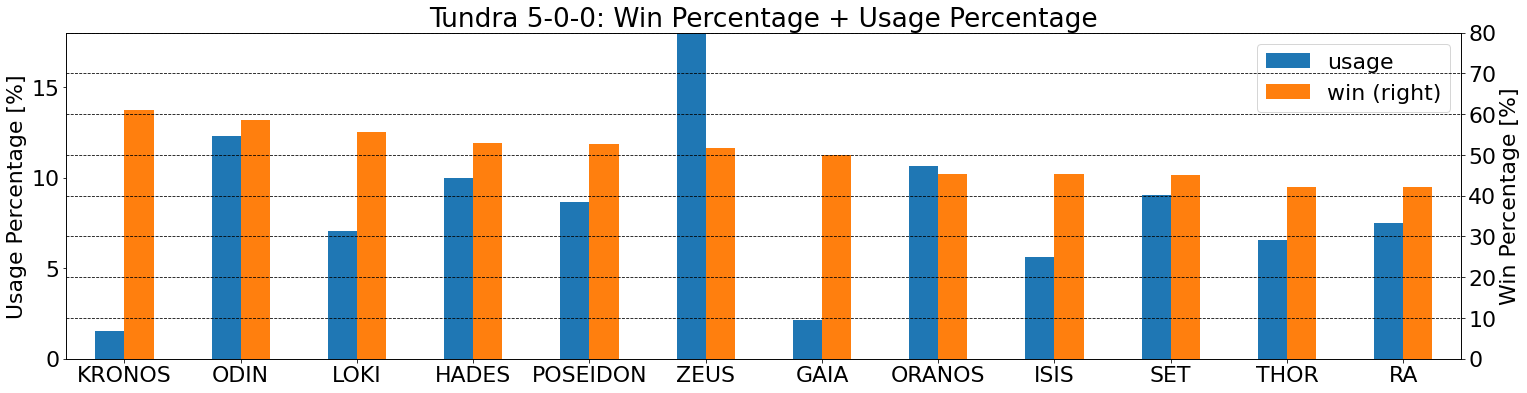

{'ODIN': [13.210445468508969, 47.49999999997031], 'POSEIDON': [10.138248847925487, 42.06349206345868], 'KRONOS': [2.380952380952198, 61.29032258044745], 'ORANOS': [9.60061443932338, 44.144144144104374], 'SET': [9.216589861750442, 45.614035087679284], 'RA': [6.605222734254484, 56.09756097554134], 'ZEUS': [18.433179723500885, 49.51456310677209], 'HADES': [9.60061443932338, 55.75221238933119], 'THOR': [6.4516129032253104, 51.24999999993594], 'LOKI': [6.2980030721961375, 59.21052631571156], 'ISIS': [5.376344086021093, 56.060606060521124], 'GAIA': [2.6881720430105465, 48.57142857128979]}


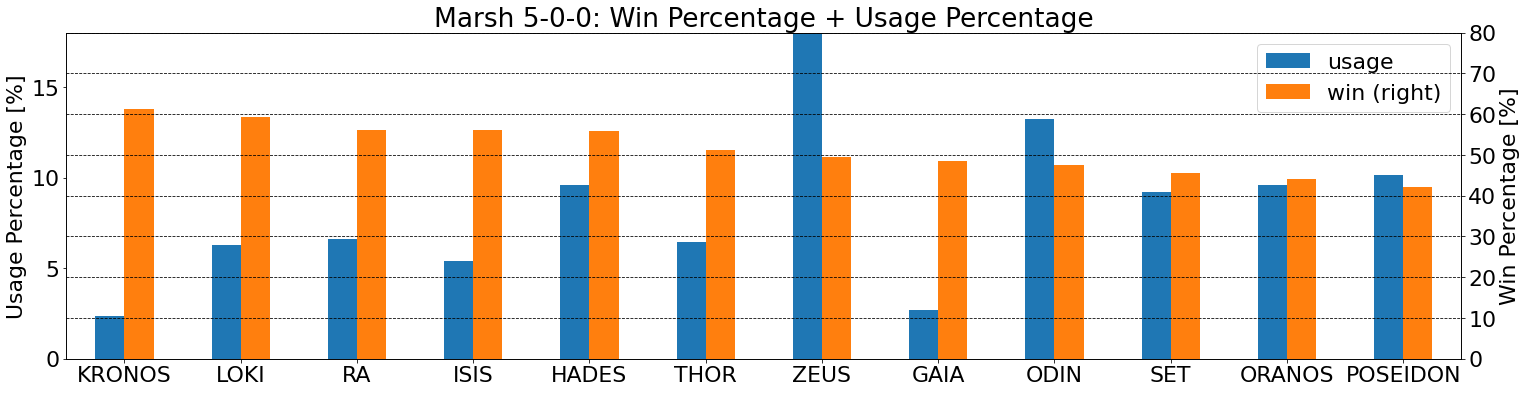

{'ORANOS': [9.552238805969436, 48.2456140350454], 'POSEIDON': [10.223880597014162, 56.589147286777845], 'ODIN': [14.179104477610881, 37.34939759033895], 'HADES': [9.999999999999254, 53.1249999999585], 'RA': [6.567164179103988, 59.523809523738656], 'SET': [8.582089552238164, 46.01769911500352], 'LOKI': [5.820895522387625, 45.83333333326968], 'ZEUS': [19.32835820895378, 52.36051502143676], 'THOR': [6.940298507462169, 53.76344086015724], 'ISIS': [5.223880597014535, 48.52941176463452], 'KRONOS': [1.4179104477610882, 57.894736841800565], 'GAIA': [2.1641791044774505, 51.851851851659816]}


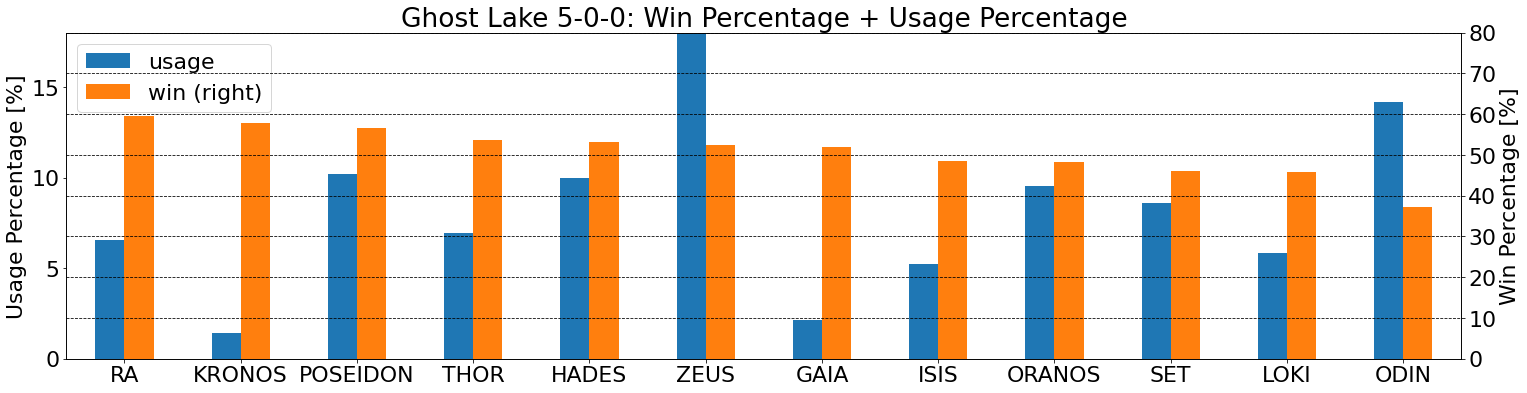

{'POSEIDON': [10.985460420031421, 56.81818181813878], 'ODIN': [12.843295638124971, 43.70860927149424], 'RA': [7.2697899838443245, 49.99999999994318], 'ORANOS': [9.854604200322306, 52.67857142852439], 'ISIS': [5.411954765750774, 53.9682539681683], 'SET': [8.562197092083315, 37.25490196074779], 'HADES': [9.208400646202811, 61.818181818125616], 'ZEUS': [17.85137318255106, 57.59162303661907], 'THOR': [7.2697899838443245, 40.69767441855733], 'LOKI': [6.7043618739897655, 35.064935064889525], 'KRONOS': [1.1308562197091172, 57.142857142448975], 'GAIA': [2.9079159935377294, 46.874999999853515]}


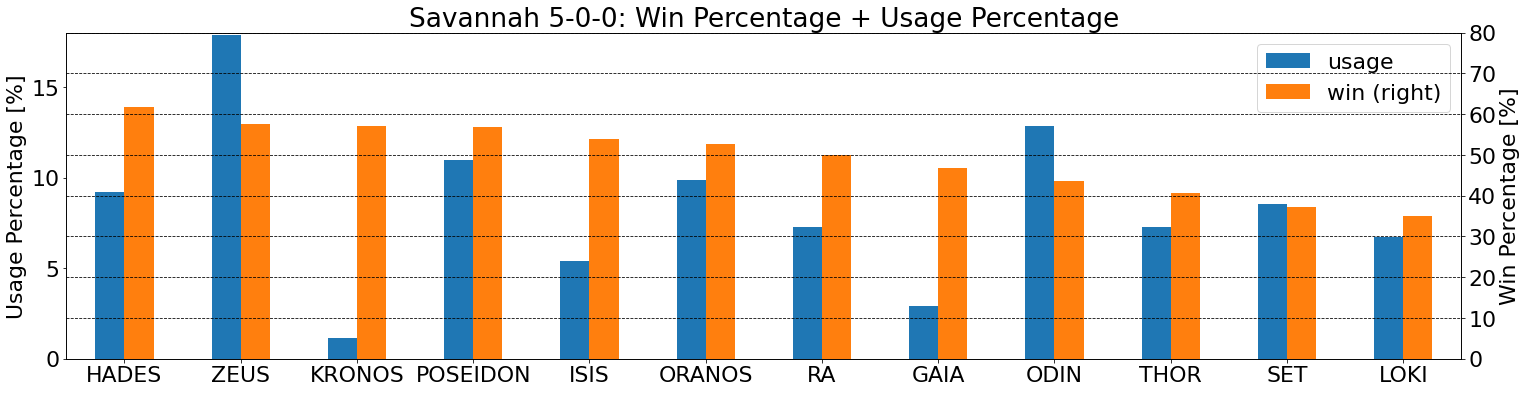

{'POSEIDON': [11.172741679872331, 61.8320610686551], 'ORANOS': [10.063391442154511, 57.798165137561654], 'ODIN': [12.044374009507761, 47.22222222218943], 'ISIS': [6.180665610142141, 41.89189189183528], 'SET': [8.637083993660172, 36.69724770638835], 'RA': [8.47860538827191, 60.60606060599939], 'KRONOS': [1.1093502377178202, 57.142857142448975], 'ZEUS': [18.70047543581468, 44.17475728153196], 'LOKI': [6.101426307448011, 53.521126760488], 'HADES': [8.24088748018952, 56.99999999994299], 'THOR': [7.131537242471701, 37.17948717943951], 'GAIA': [2.1394611727415103, 55.5555555553498]}


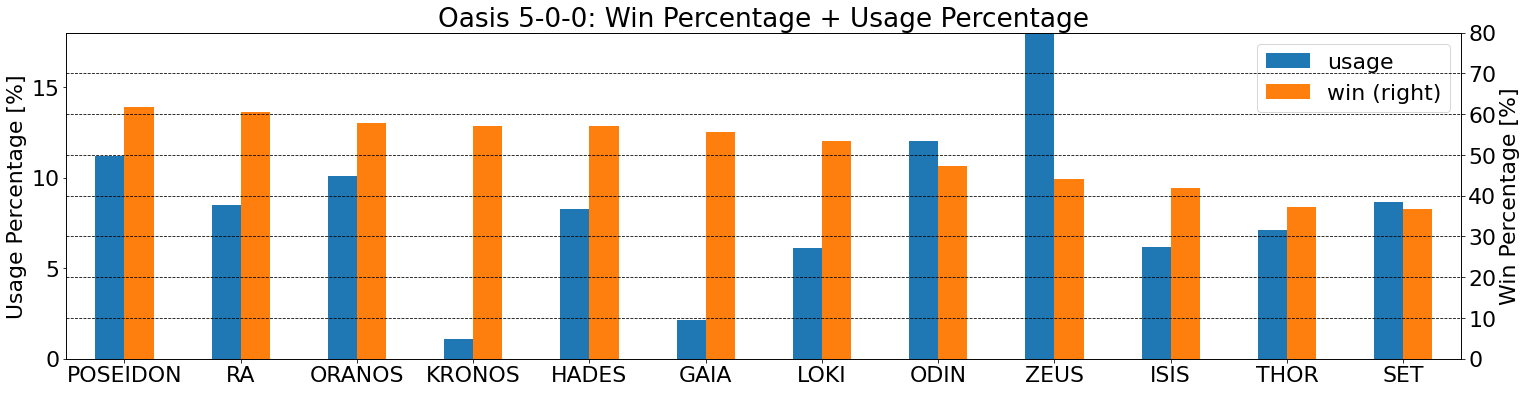

{'POSEIDON': [9.335443037973945, 58.035714285662465], 'ORANOS': [9.889240506328331, 46.218487394919144], 'HADES': [9.65189873417645, 64.03508771924209], 'SET': [8.781645569619558, 45.79439252332168], 'ZEUS': [17.563291139239116, 59.99999999996842], 'THOR': [8.386075949366425, 42.30769230765163], 'ODIN': [11.392405063290239, 25.78124999997986], 'RA': [8.069620253163919, 59.37499999993815], 'KRONOS': [1.1867088607593996, 59.99999999959999], 'LOKI': [5.933544303796999, 32.39436619713747], 'ISIS': [6.962025316455145, 51.19047619041525], 'GAIA': [2.8481012658225597, 64.70588235275086]}


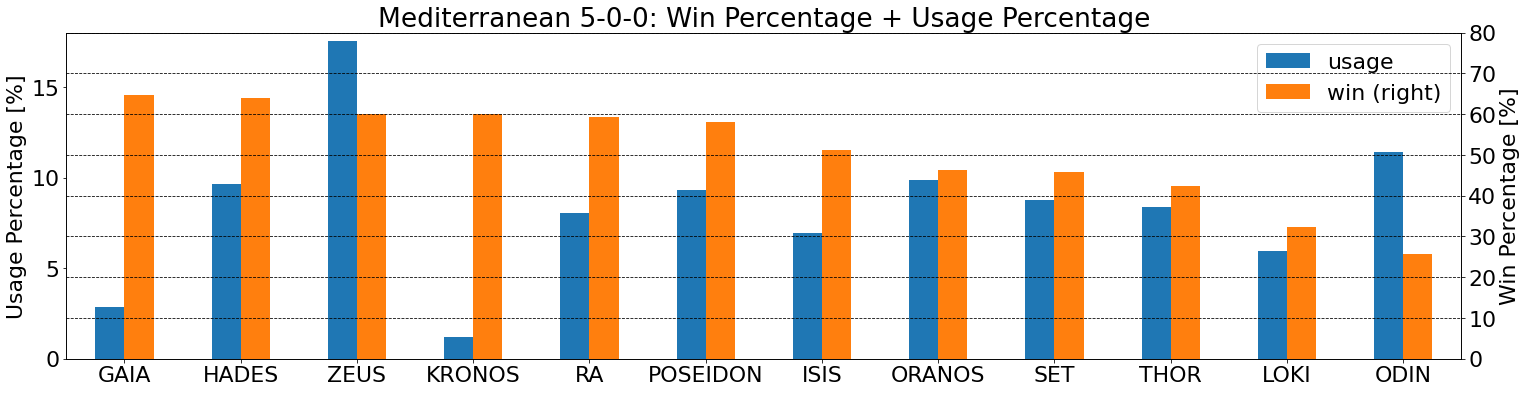

{'GAIA': [3.140916808149139, 54.05405405390796], 'SET': [7.640067911714123, 36.90476190471797], 'ODIN': [13.752122241085418, 49.99999999996667], 'POSEIDON': [10.18675721561883, 52.830188679195444], 'ZEUS': [17.48726655347899, 47.87234042550645], 'RA': [6.876061120542709, 50.63291139234097], 'ORANOS': [10.27164685908232, 49.55752212384995], 'LOKI': [6.366723259761768, 43.47826086950221], 'ISIS': [5.602716468590356, 49.99999999991071], 'THOR': [7.385398981323651, 61.445783132456086], 'HADES': [9.847198641764868, 55.555555555504114], 'KRONOS': [1.4431239388793342, 47.058823529134955]}


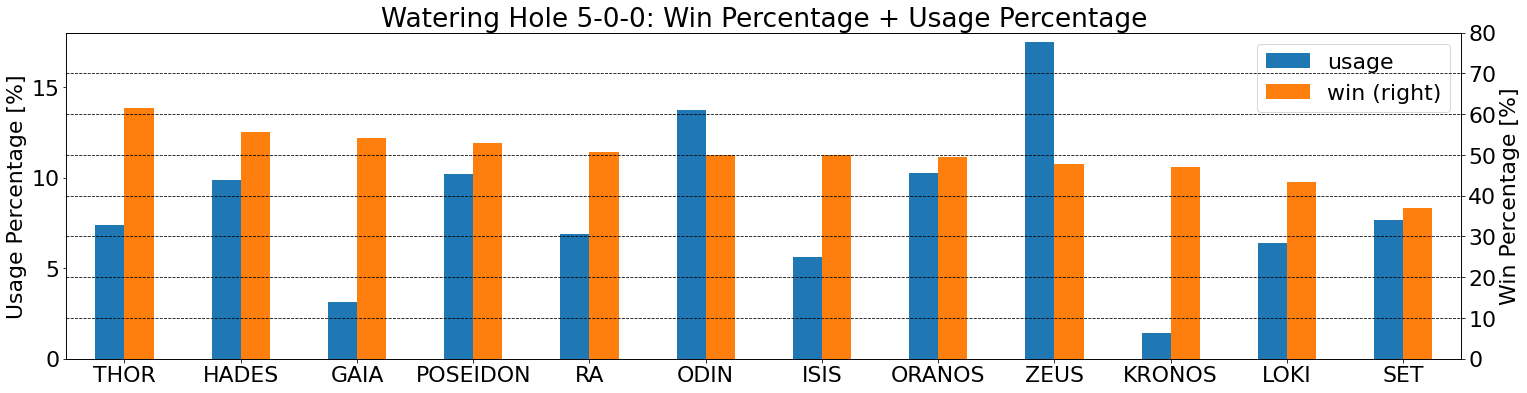

{'POSEIDON': [9.881422924900209, 49.99999999994681], 'RA': [7.114624505928151, 59.72222222213928], 'ODIN': [12.351778656125262, 40.17094017090584], 'ORANOS': [11.561264822133245, 48.62385321096456], 'ZEUS': [19.268774703555408, 49.707602339152224], 'THOR': [7.312252964426155, 49.99999999993056], 'HADES': [9.090909090908191, 49.99999999994048], 'SET': [9.4861660079042, 42.55319148931643], 'ISIS': [5.632411067193119, 64.9122807016405], 'LOKI': [4.446640316205094, 62.79069767427258], 'GAIA': [2.6679841897230565, 40.74074074058986], 'KRONOS': [1.185770750988025, 66.66666666611111]}


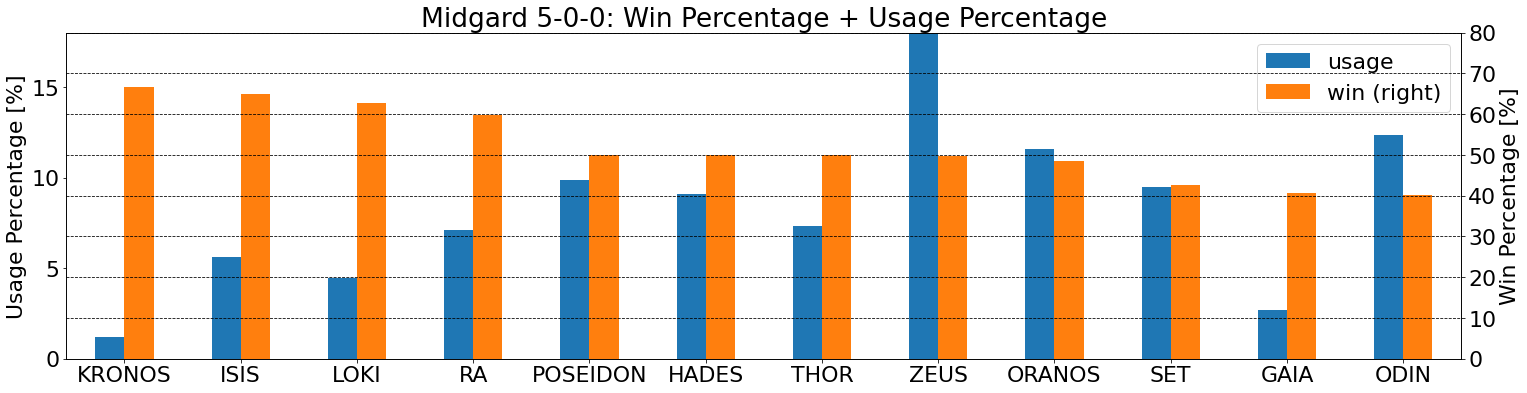

{'POSEIDON': [11.06032906764067, 51.282051282007444], 'ODIN': [11.608775137110456, 34.453781512576086], 'RA': [9.414990859231315, 67.74193548379812], 'ORANOS': [8.86654478976153, 36.26373626369641], 'HADES': [10.329067641680957, 62.85714285708299], 'GAIA': [2.2851919561241054, 39.99999999984], 'ZEUS': [19.01279707495256, 54.444444444414195], 'THOR': [6.124314442412603, 36.92307692302011], 'ISIS': [4.661791590493175, 50.980392156762775], 'SET': [9.597806215721242, 54.54545454539945], 'LOKI': [5.758683729432746, 44.26229508189465], 'KRONOS': [1.2797074954294991, 57.142857142448975]}


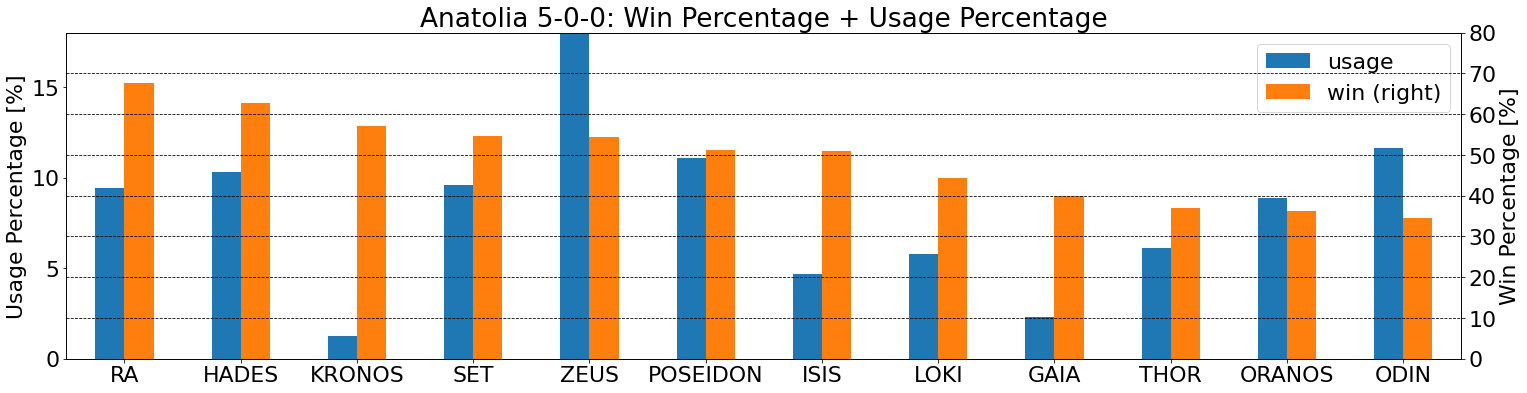

{'POSEIDON': [10.059347181008603, 53.25077399379157], 'ORANOS': [10.059347181008603, 44.200626959233794], 'RA': [8.219584569732694, 62.45210727966957], 'ODIN': [11.750741839762261, 33.24175824174911], 'HADES': [9.703264094955202, 59.73597359734002], 'SET': [9.258160237388449, 47.666666666650784], 'GAIA': [2.6112759643916137, 49.999999999941856], 'ZEUS': [18.54599406528135, 54.89833641403791], 'THOR': [7.329376854599189, 43.153526970936454], 'ISIS': [5.8160237388722305, 55.20833333330458], 'KRONOS': [1.2166172106824564, 60.97560975594883], 'LOKI': [5.430267062314379, 43.99999999997486]}


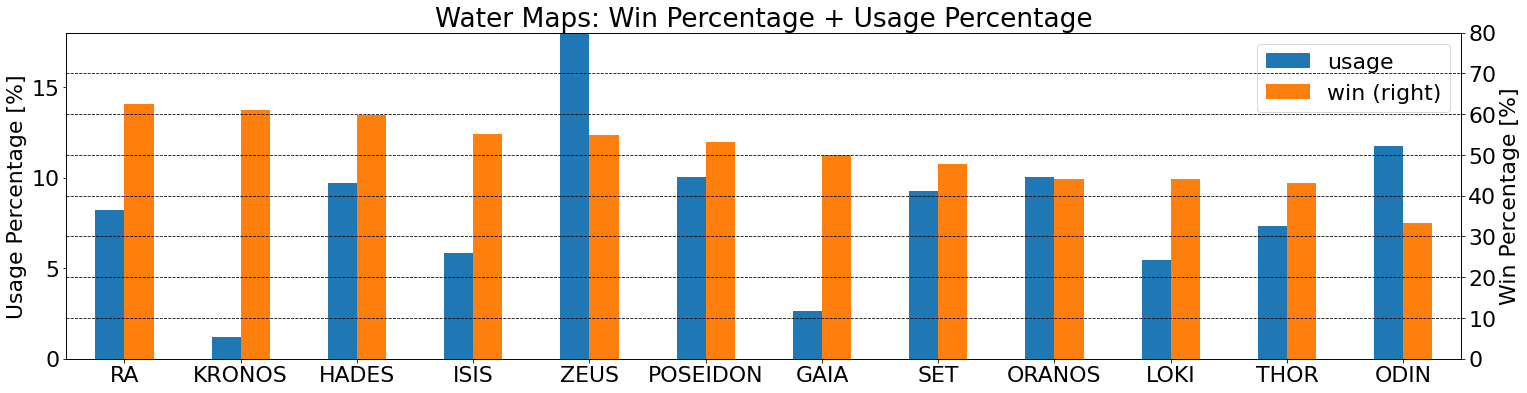

{'POSEIDON': [10.14234875444832, 55.077173030052386], 'ORANOS': [10.165557790499689, 53.32197614991028], 'ZEUS': [18.28872040847889, 49.278152069295025], 'RA': [7.442364227139042, 53.45572354211085], 'ODIN': [13.09763267832266, 46.54615881213386], 'SET': [8.370725669193808, 42.84332688587593], 'GAIA': [2.359585331889197, 48.432055749112045], 'HADES': [9.492495745009984, 54.58440445586508], 'KRONOS': [1.5550054154417332, 54.40414507769202], 'LOKI': [6.3824849141265165, 45.84980237153546], 'ISIS': [5.678477487234987, 49.27745664739172], 'THOR': [7.024601578214397, 48.61111111110548]}


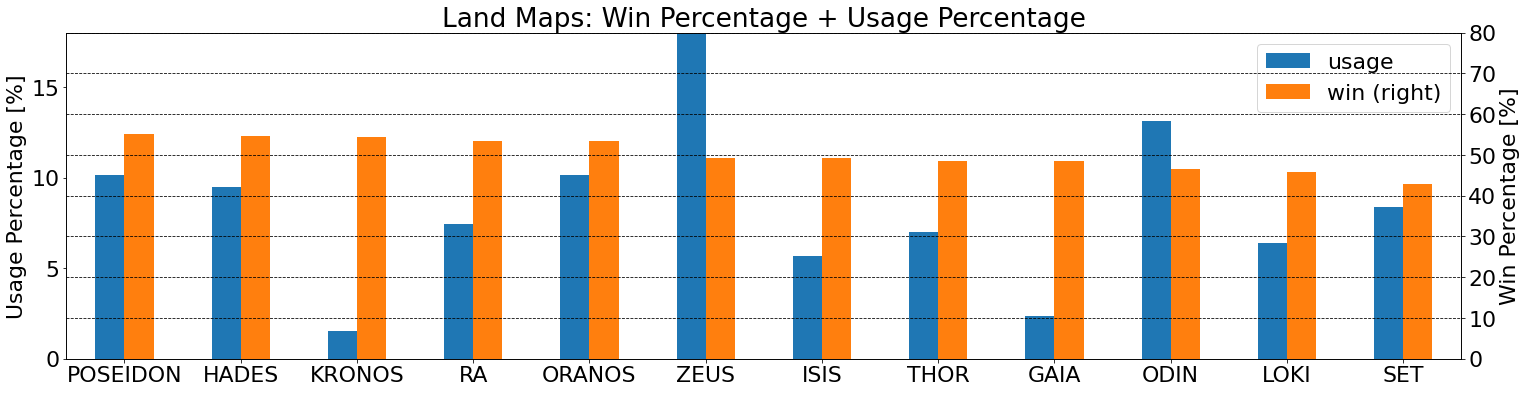

VBP4.0 Total Games after filtering:
(16577, 10)
VBP4.0 Total Games with available map information after filtering:
35
VBP5.0 Total Games after filtering:
(10859, 10)
VBP5.0 Total Games with available map information after filtering:
8232


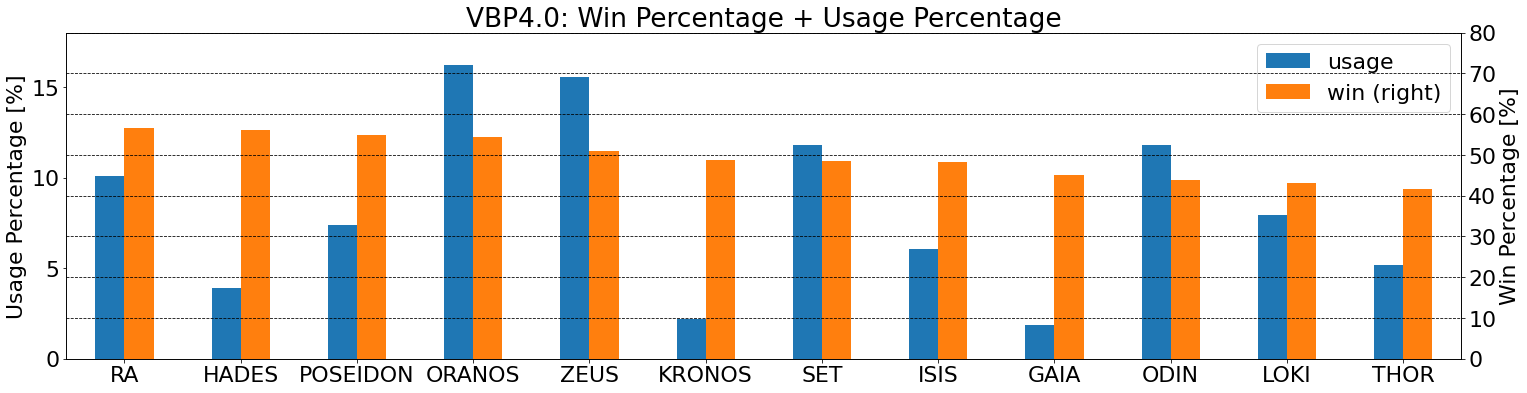

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


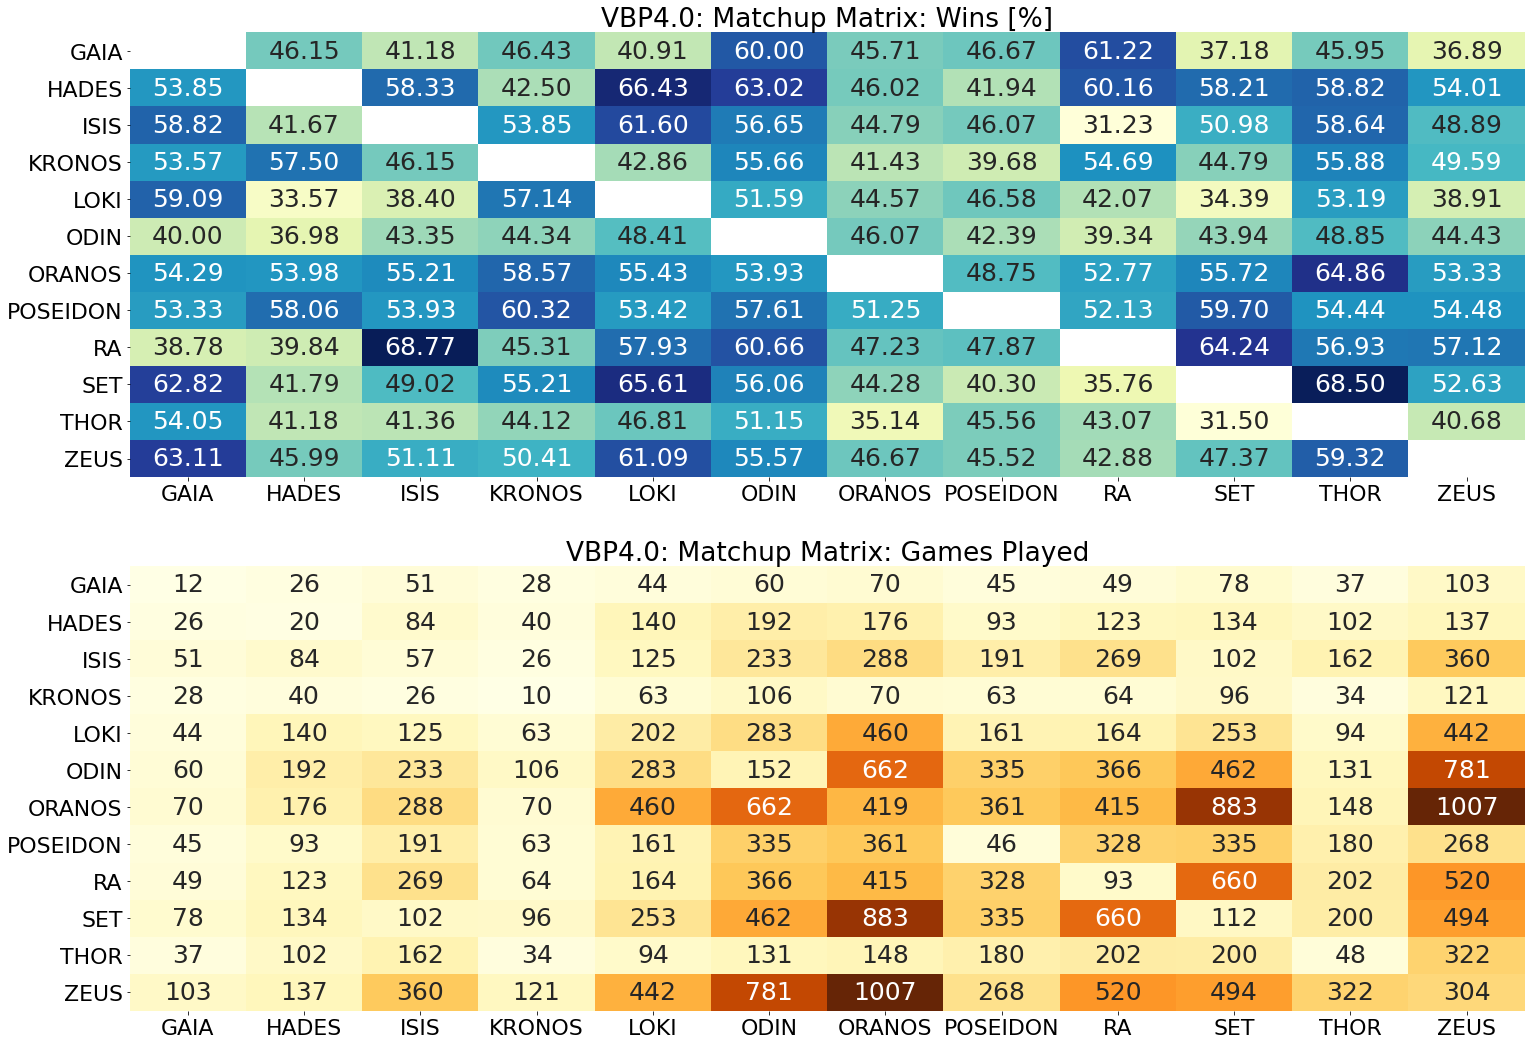

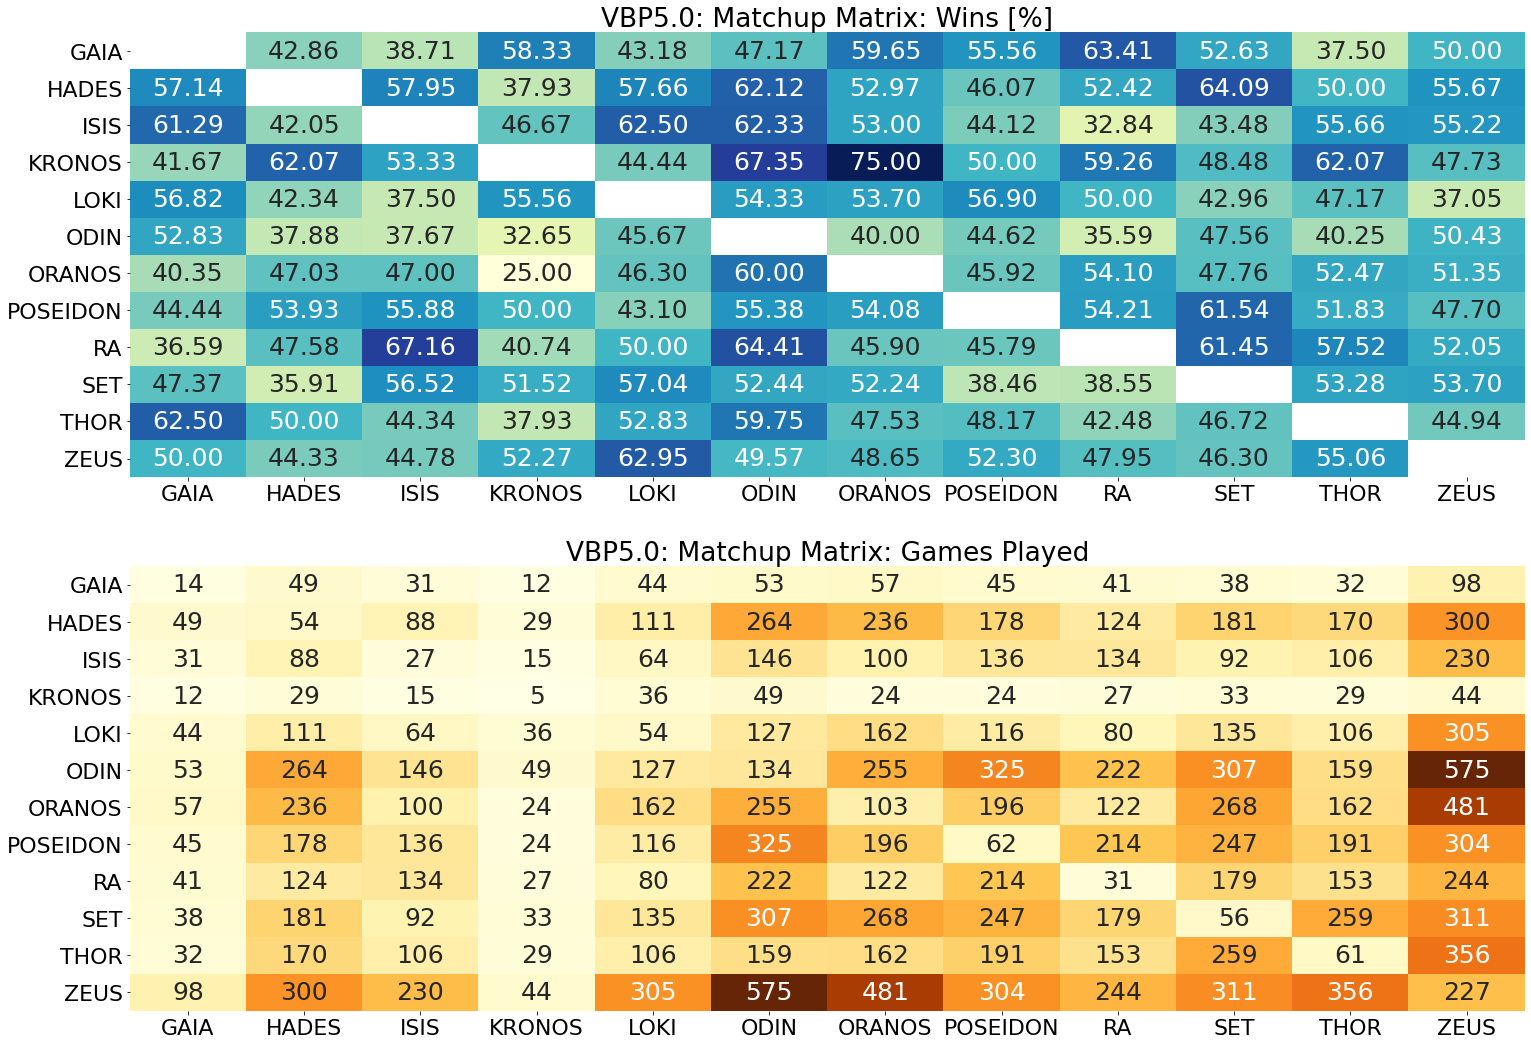

None
/home/leonard/Documents/AOT_LadderStats
/home/leonard/Documents/AOT_LadderStats/Stats02_10_2021_1800


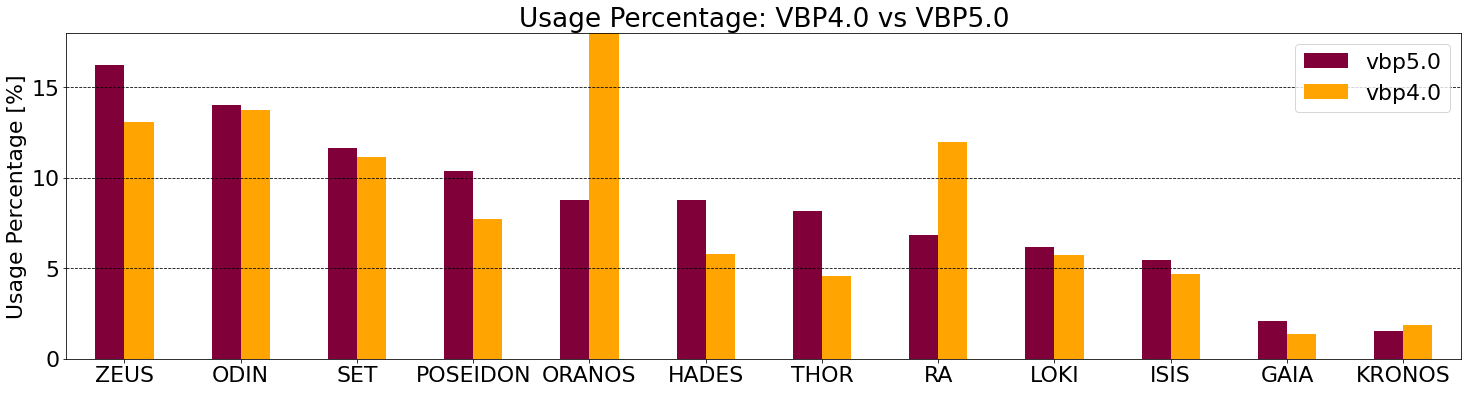

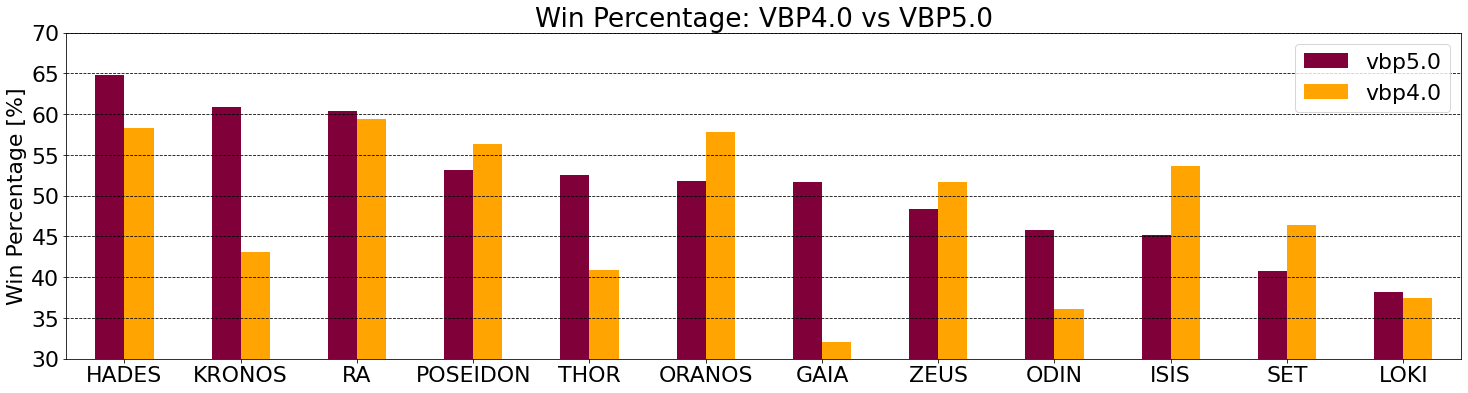

Standard Deviation of usage:
vbp5.0    4.186033
vbp4.0    5.041027
dtype: float64
Standard Deviation of win percentages:
vbp5.0    7.750240
vbp4.0    9.273013
dtype: float64
Differences in usage:
Index(['ORANOS', 'RA', 'KRONOS', 'ODIN', 'SET', 'LOKI', 'GAIA', 'ISIS',
       'POSEIDON', 'HADES', 'ZEUS', 'THOR'],
      dtype='object')
[-9.58400752 -5.16621544 -0.31373423  0.30470442  0.44736591  0.46028156
  0.74644859  0.75883871  2.64514588  2.97754491  3.15885782  3.5647694 ]
Differences in win:
Index(['ISIS', 'ORANOS', 'SET', 'ZEUS', 'POSEIDON', 'LOKI', 'RA', 'HADES',
       'ODIN', 'THOR', 'KRONOS', 'GAIA'],
      dtype='object')
[-8.46284289 -6.1167128  -5.653854   -3.39834608 -3.16249842  0.76842326
  0.90999223  6.53991971  9.71271952 11.59933853 17.86273329 19.62520857]
{'RA': [6.147540983605298, 83.33333333305556], 'POSEIDON': [10.450819672129006, 57.777777777649376], 'ODIN': [14.549180327865871, 37.68115942023525], 'LOKI': [8.81147540983426, 20.512820512767917], 'ORANOS': [7.9

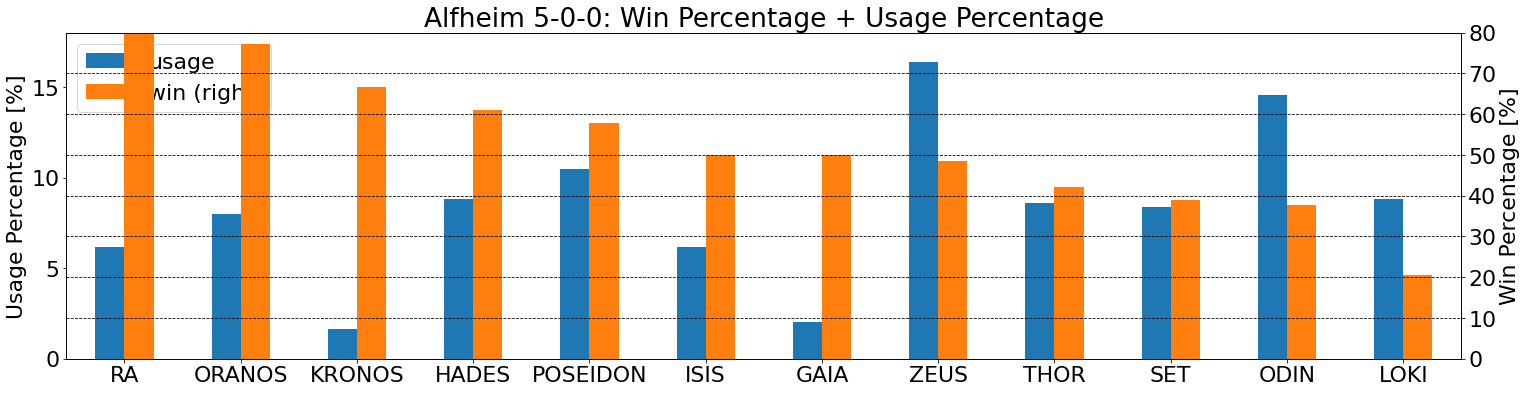

{'POSEIDON': [9.999999999998076, 66.66666666652777], 'ODIN': [13.461538461535872, 53.12499999991699], 'ORANOS': [8.846153846152143, 39.47368421042244], 'LOKI': [7.884615384613867, 31.428571428481632], 'THOR': [7.115384615383247, 54.28571428555918], 'KRONOS': [1.5384615384612423, 49.999999999375], 'ISIS': [5.961538461537315, 51.61290322563996], 'SET': [8.653846153844489, 37.20930232549486], 'HADES': [10.384615384613387, 55.55555555545267], 'ZEUS': [16.538461538458357, 51.24999999993594], 'RA': [7.307692307690902, 55.26315789459141], 'GAIA': [2.307692307691864, 24.9999999996875]}


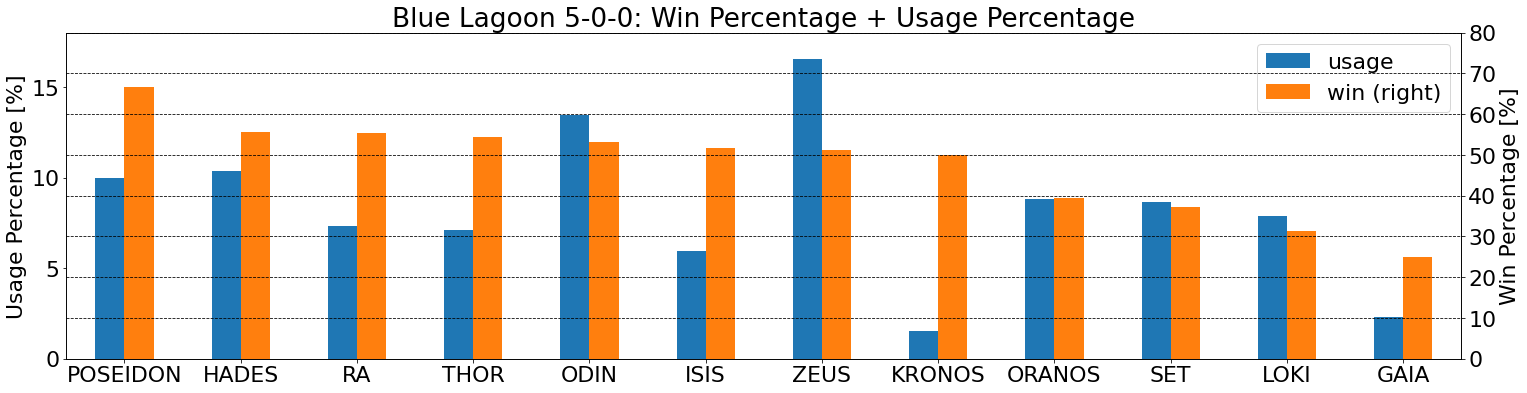

{'POSEIDON': [9.799999999998041, 55.5555555554321], 'ZEUS': [17.9999999999964, 34.14634146337299], 'ORANOS': [10.59999999999788, 62.22222222208394], 'SET': [8.39999999999832, 29.999999999925], 'GAIA': [1.5999999999996801, 66.66666666555555], 'KRONOS': [1.3999999999997201, 57.14285714204082], 'LOKI': [7.19999999999856, 47.058823529273354], 'ODIN': [14.799999999997041, 59.09090909081955], 'THOR': [5.19999999999896, 53.84615384594675], 'ISIS': [4.999999999999001, 30.434782608563328], 'HADES': [9.999999999998002, 71.73913043462665], 'RA': [7.9999999999984, 49.999999999868415]}


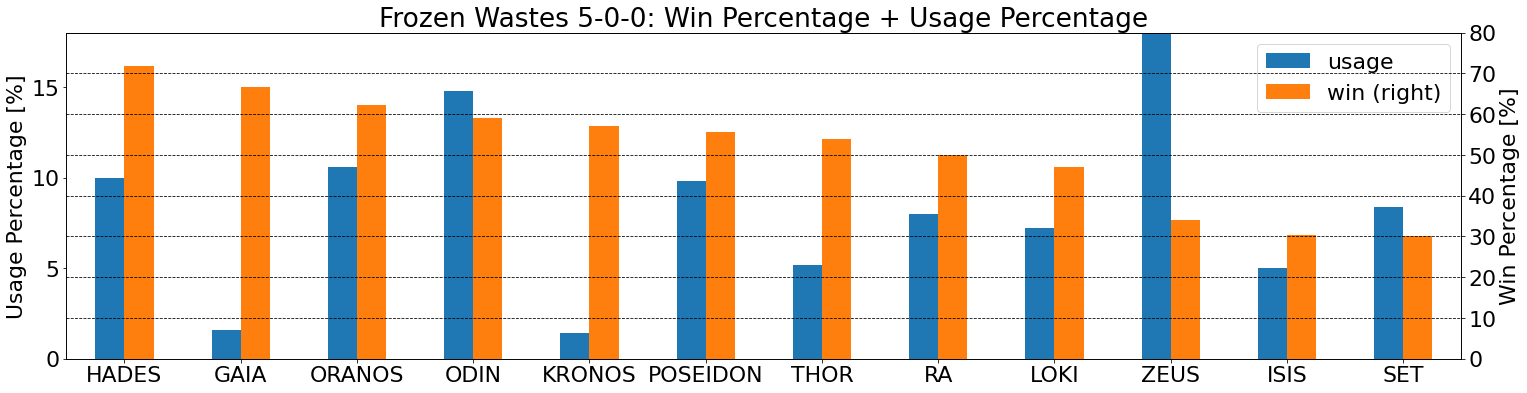

{'POSEIDON': [9.067357512951018, 48.48484848470156], 'SET': [13.2124352331572, 46.511627906868576], 'ODIN': [13.730569948182971, 40.81632653052895], 'HADES': [9.585492227976792, 56.75675675660335], 'LOKI': [5.440414507770611, 42.85714285693878], 'THOR': [9.844559585489678, 64.70588235275086], 'ZEUS': [17.098445595850492, 46.55172413785077], 'KRONOS': [1.5544041450773176, 83.33333333194444], 'ORANOS': [9.844559585489678, 47.058823529273354], 'ISIS': [4.922279792744839, 52.941176470276815], 'RA': [4.663212435231952, 66.66666666629631], 'GAIA': [1.036269430051545, 0.0]}


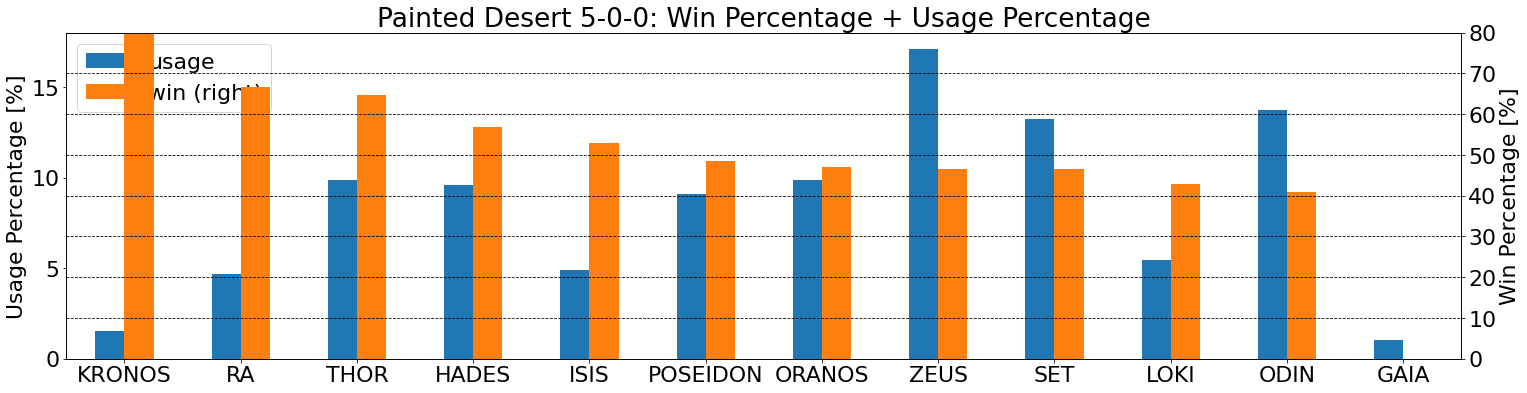

{'POSEIDON': [8.367346938773803, 63.414634146186785], 'ORANOS': [7.755102040814744, 47.36842105250692], 'RA': [6.938775510202666, 44.11764705869377], 'ODIN': [14.48979591836439, 62.31884057961983], 'HADES': [11.836734693875135, 56.24999999988282], 'GAIA': [0.8163265306120783, 49.99999999875], 'LOKI': [7.551020408161724, 39.99999999988571], 'SET': [11.836734693875135, 36.53846153839127], 'ZEUS': [16.938775510200628, 50.66666666659911], 'KRONOS': [1.836734693877176, 57.14285714204082], 'THOR': [6.530612244896626, 43.749999999863284], 'ISIS': [5.10204081632549, 39.99999999984]}


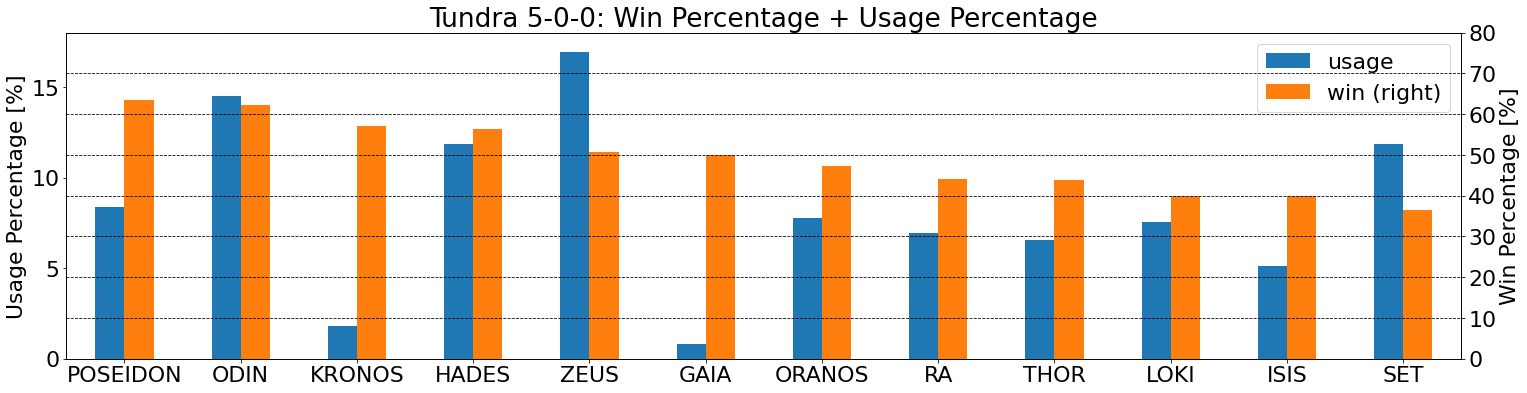

{'ODIN': [16.30901287553298, 55.71428571420613], 'POSEIDON': [10.300429184547145, 43.478260869470695], 'KRONOS': [2.360515021458721, 45.45454545413223], 'ORANOS': [9.656652360512949, 46.153846153727805], 'SET': [11.58798283261554, 35.999999999928], 'ZEUS': [17.81115879827944, 42.66666666660978], 'HADES': [8.369098712444556, 59.459459459298756], 'RA': [5.364806866951639, 63.999999999744006], 'LOKI': [5.79399141630777, 47.999999999808004], 'ISIS': [4.506437768239376, 66.66666666634922], 'GAIA': [3.0042918454929177, 57.142857142448975], 'THOR': [4.935622317595508, 60.869565217126656]}


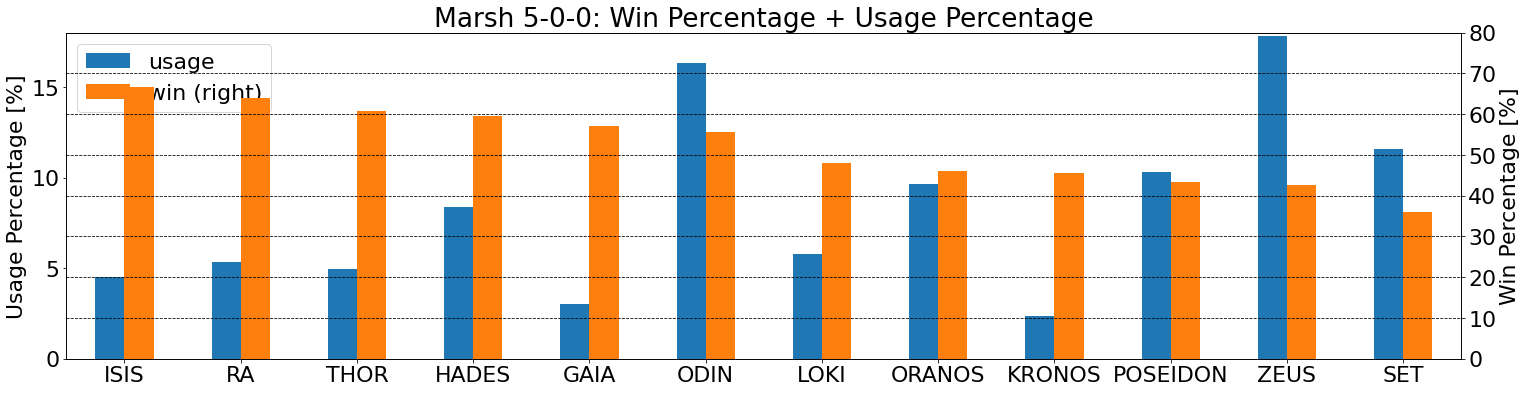

{'ORANOS': [10.162601626014196, 52.27272727260846], 'POSEIDON': [9.959349593493911, 53.19148936158895], 'ODIN': [14.227642276419871, 40.62499999993652], 'HADES': [11.585365853656182, 52.72727272717685], 'RA': [5.487804878047665, 81.48148148117971], 'SET': [9.146341463412776, 42.222222222128394], 'LOKI': [5.894308943088233, 41.3793103446849], 'ZEUS': [19.918699186987823, 49.99999999994681], 'ISIS': [5.487804878047665, 37.03703703689987], 'THOR': [5.894308943088233, 55.1724137929132], 'KRONOS': [0.8130081300811356, 99.9999999975], 'GAIA': [1.4227642276419874, 39.9999999992]}


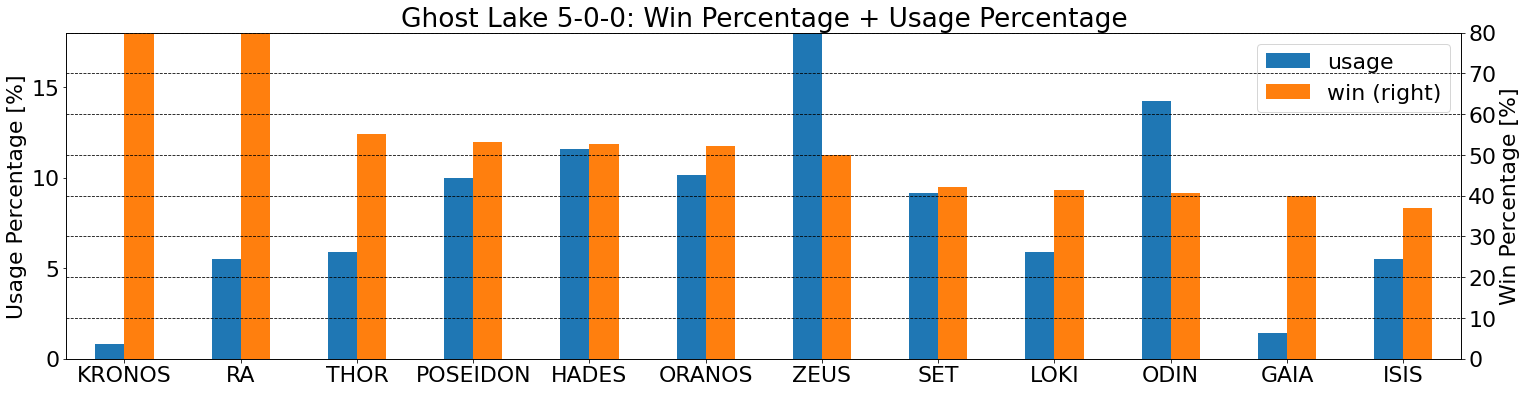

{'POSEIDON': [14.039408866991614, 56.363636363533885], 'ODIN': [16.502463054183128, 44.4444444443739], 'RA': [5.911330049259628, 37.49999999984375], 'ORANOS': [9.113300492608593, 54.28571428555918], 'ISIS': [5.172413793102174, 57.14285714258504], 'SET': [9.359605911327744, 27.777777777700617], 'HADES': [7.389162561574534, 78.57142857114796], 'ZEUS': [14.039408866991614, 54.54545454535536], 'THOR': [7.6354679802936865, 58.06451612884496], 'LOKI': [7.6354679802936865, 32.25806451602497], 'GAIA': [2.7093596059106626, 55.55555555493827], 'KRONOS': [0.4926108374383023, 49.9999999975]}


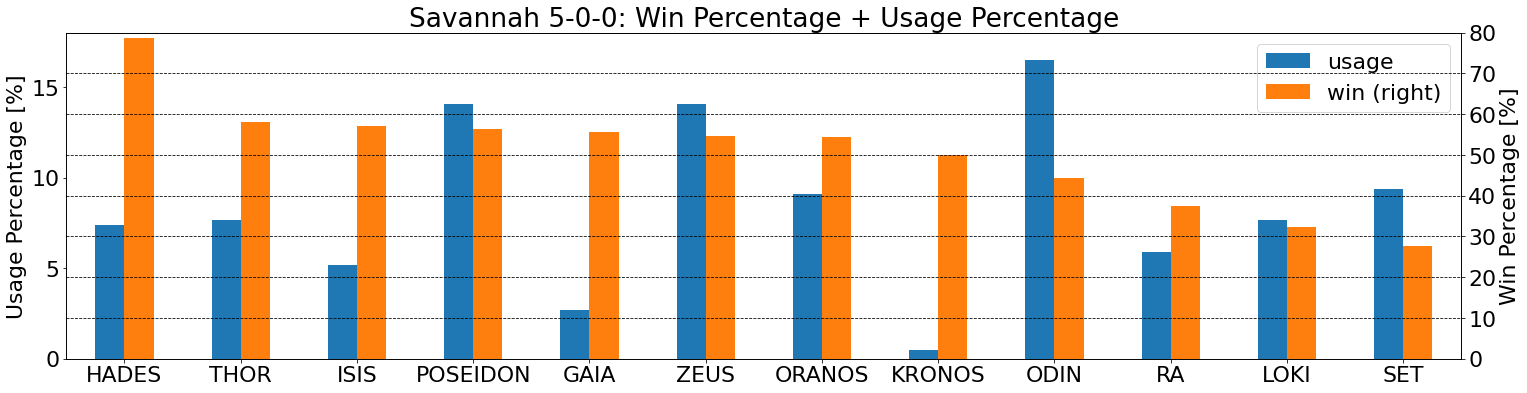

{'POSEIDON': [11.383928571426031, 59.18367346926697], 'ORANOS': [7.812499999998257, 55.1724137929132], 'ODIN': [14.062499999996861, 56.14035087709449], 'ISIS': [7.812499999998257, 39.99999999988571], 'SET': [9.598214285712144, 30.232558139464572], 'RA': [7.812499999998257, 59.99999999982857], 'KRONOS': [2.008928571428123, 44.444444443950616], 'ZEUS': [18.303571428567345, 39.70588235288278], 'LOKI': [7.142857142855549, 57.14285714265307], 'HADES': [6.919642857141313, 58.06451612884496], 'THOR': [4.464285714284718, 44.99999999977501], 'GAIA': [2.6785714285708306, 74.999999999375]}


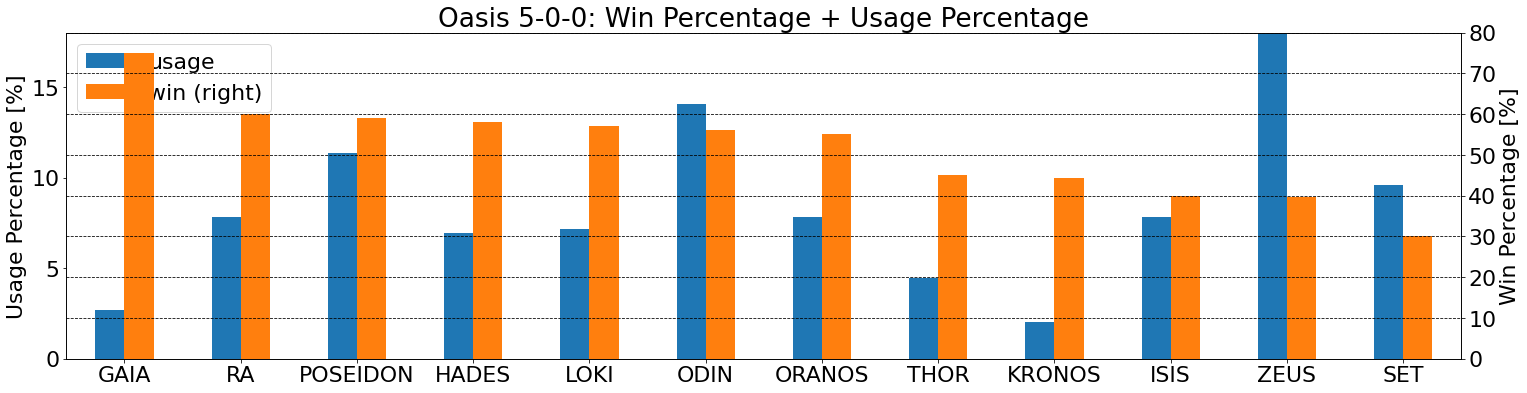

{'POSEIDON': [8.888888888886914, 60.5263157893144], 'ORANOS': [10.444444444442123, 51.111111110997534], 'HADES': [10.666666666664296, 76.19047619029477], 'SET': [8.888888888886914, 23.68421052625346], 'ZEUS': [17.555555555551656, 56.52173913035286], 'THOR': [6.888888888887358, 48.38709677403747], 'ODIN': [15.5555555555521, 27.586206896504162], 'RA': [7.111111111109531, 66.66666666644446], 'LOKI': [5.333333333332148, 33.333333333194446], 'ISIS': [5.777777777776494, 45.83333333314236], 'KRONOS': [1.1111111111108642, 79.9999999984], 'GAIA': [1.7777777777773827, 74.99999999906251]}


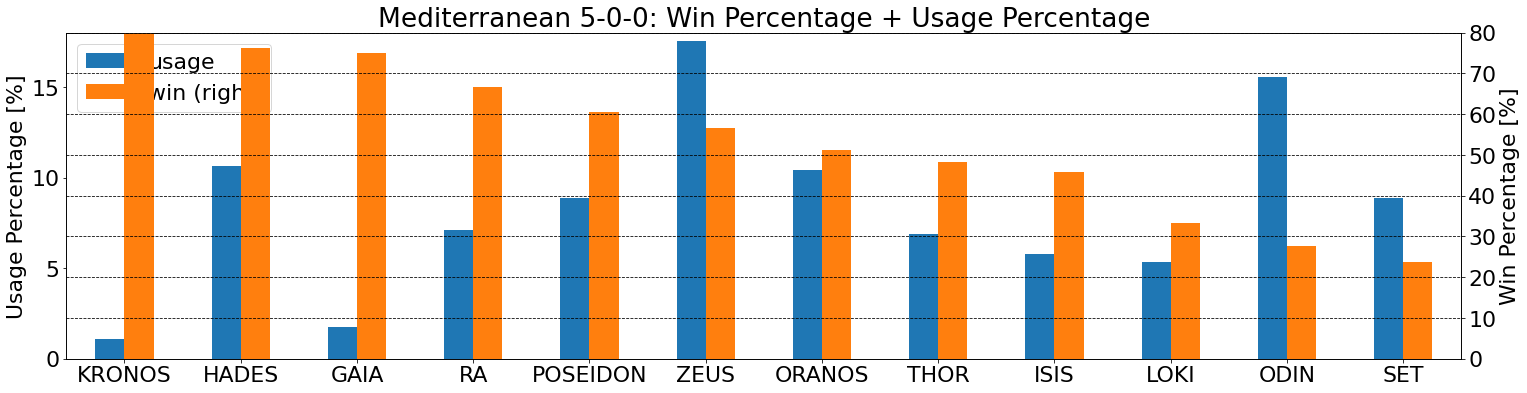

{'GAIA': [4.187192118225569, 64.70588235256056], 'SET': [10.098522167485198, 43.589743589631816], 'ODIN': [14.778325123149068, 57.1428571427551], 'POSEIDON': [9.605911330046895, 51.42857142842448], 'ZEUS': [17.487684729059733, 34.92063492057949], 'ORANOS': [7.389162561574534, 33.33333333322223], 'LOKI': [6.896551724136232, 46.153846153668646], 'ISIS': [3.9408866995064185, 35.714285714030616], 'THOR': [7.6354679802936865, 70.96774193525495], 'HADES': [9.605911330046895, 67.56756756738494], 'KRONOS': [2.2167487684723604, 44.444444443950616], 'RA': [6.157635467978779, 51.999999999792]}


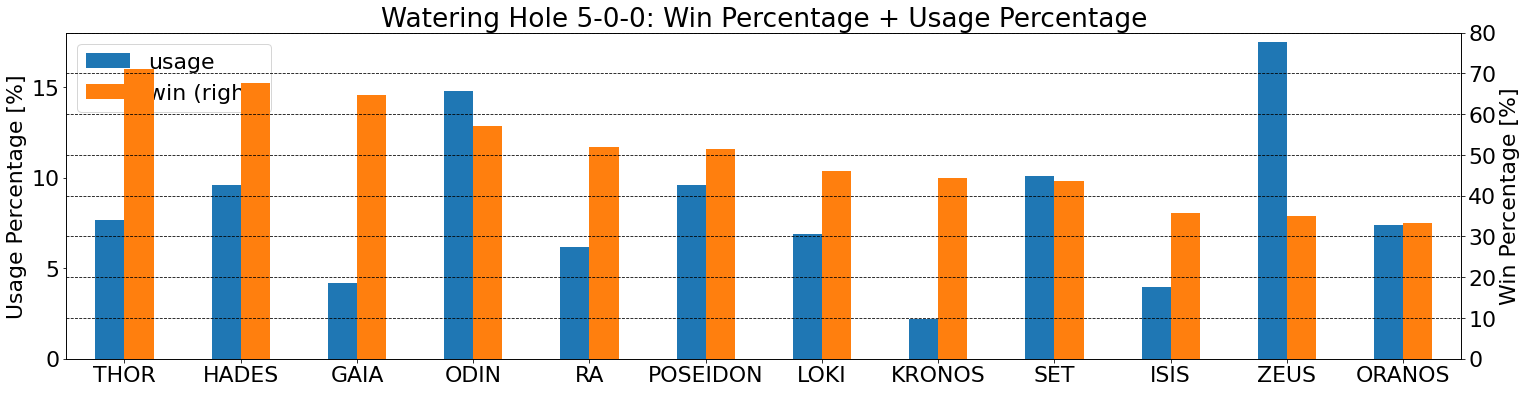

{'POSEIDON': [9.944751381212722, 56.24999999982422], 'RA': [5.801104972374088, 57.14285714258504], 'ODIN': [12.983425414361054, 42.553191489271164], 'ORANOS': [11.878453038670752, 43.243243243126365], 'ZEUS': [14.917127071819083, 43.999999999912], 'THOR': [8.011049723754693, 58.620689654970285], 'HADES': [11.878453038670752, 64.10256410239974], 'SET': [12.430939226515903, 39.53488372083829], 'ISIS': [4.143646408838634, 53.33333333297777], 'LOKI': [4.41988950276121, 56.249999999648445], 'GAIA': [2.7624309392257564, 49.9999999995], 'KRONOS': [0.828729281767727, 66.66666666444443]}


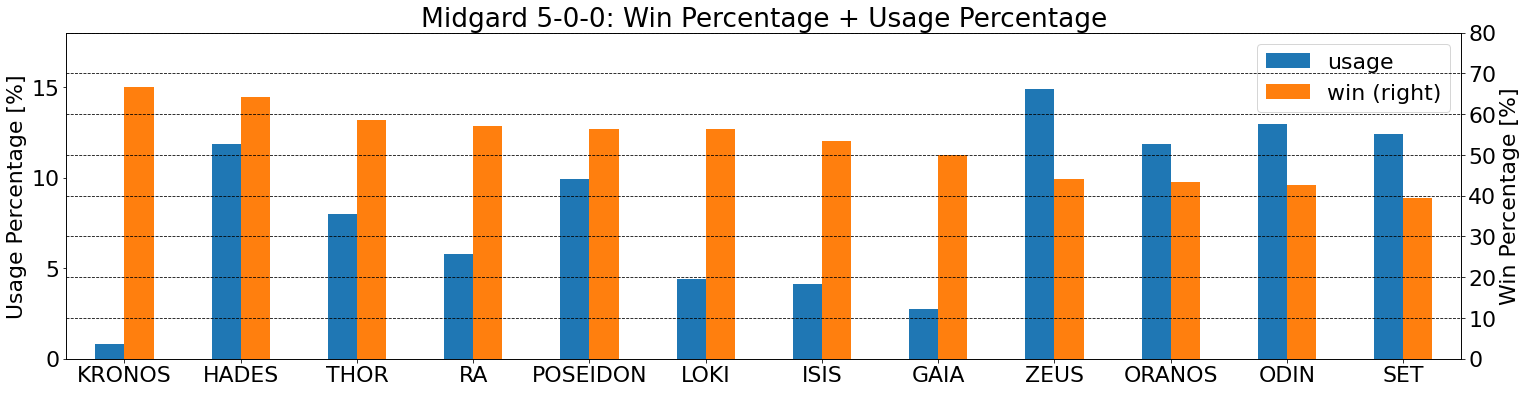

{'POSEIDON': [14.950980392153198, 52.54237288126687], 'ODIN': [13.480392156859441, 33.33333333326797], 'RA': [7.843137254900038, 69.99999999976667], 'ORANOS': [6.617647058821907, 25.925925925829908], 'HADES': [10.539215686271927, 81.08108108086194], 'GAIA': [2.6960784313718884, 45.45454545413223], 'ZEUS': [16.911764705878205, 58.46153846144851], 'THOR': [5.637254901959403, 30.434782608563328], 'ISIS': [4.166666666665646, 41.17647058799309], 'SET': [10.049019607840675, 51.219512194997016], 'LOKI': [5.637254901959403, 26.08695652162571], 'KRONOS': [1.4705882352937574, 83.33333333194444]}


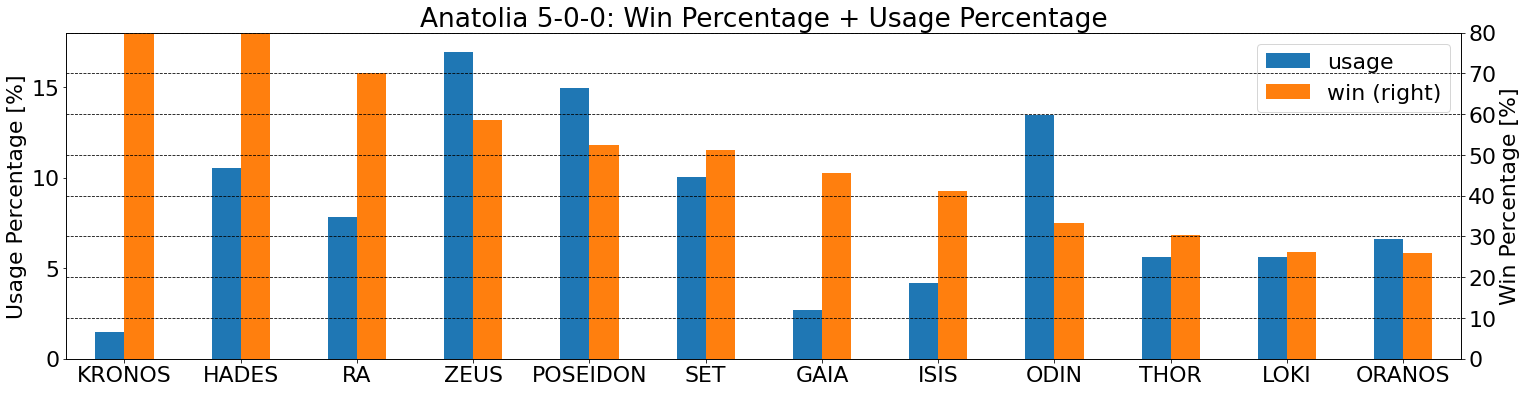

{'POSEIDON': [11.22950819672039, 55.81395348832883], 'ORANOS': [9.590163934425442, 42.2018348623466], 'RA': [6.967213114753528, 65.43209876535133], 'ODIN': [14.098360655736549, 33.9743589743372], 'HADES': [10.983606557376149, 73.72881355925955], 'SET': [10.327868852458169, 38.52459016390285], 'GAIA': [2.3770491803276736, 55.1724137929132], 'ZEUS': [16.55737704917897, 53.80434782605772], 'THOR': [6.803278688524032, 46.9879518071723], 'ISIS': [4.754098360655347, 46.42857142848852], 'LOKI': [5.163934426229084, 36.507936507878554], 'KRONOS': [1.1475409836064634, 78.57142857086735]}


{'POSEIDON': [10.256410256410033, 55.855855855843274], 'ORANOS': [8.930899608865516, 51.77111716619843], 'ZEUS': [17.296827466318614, 45.2908587257555], 'RA': [6.431986093002902, 58.84353741494598], 'ODIN': [14.667535853976213, 50.87719298244803], 'SET': [9.952194697957193, 37.03703703702846], 'GAIA': [2.1512385919165116, 53.93258426960232], 'HADES': [9.517601043024564, 60.86956521737661], 'KRONOS': [1.586266840504094, 56.52173913035286], 'LOKI': [7.062146892655213, 39.60396039602653], 'ISIS': [5.432420686657856, 45.867768595022376], 'THOR': [6.714471968709111, 54.849498327740854]}


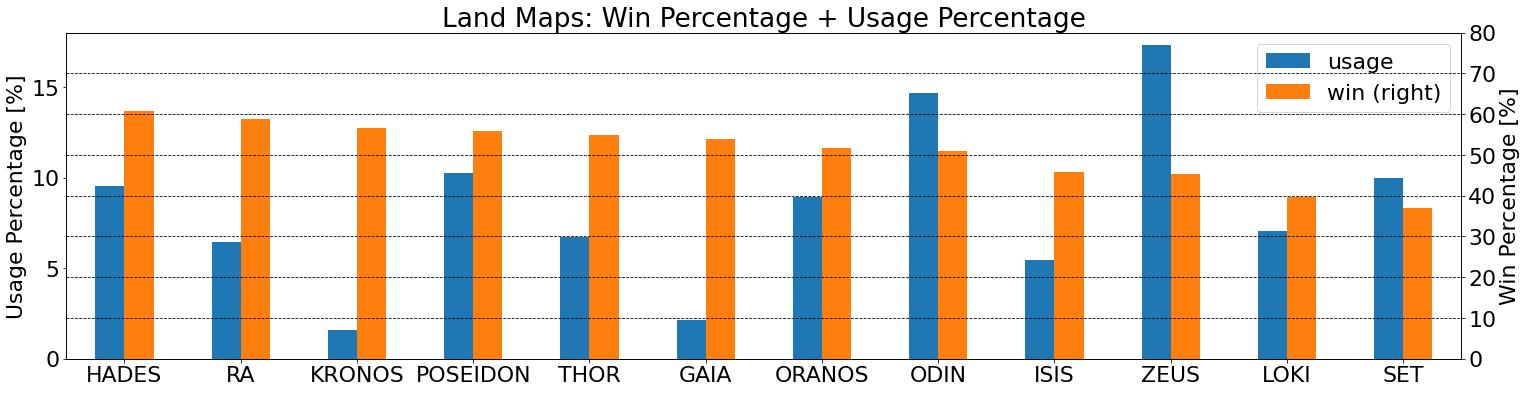

VBP4.0 Total Games after filtering:
(4175, 10)
VBP4.0 Total Games with available map information after filtering:
1
VBP5.0 Total Games after filtering:
(3760, 10)
VBP5.0 Total Games with available map information after filtering:
2938


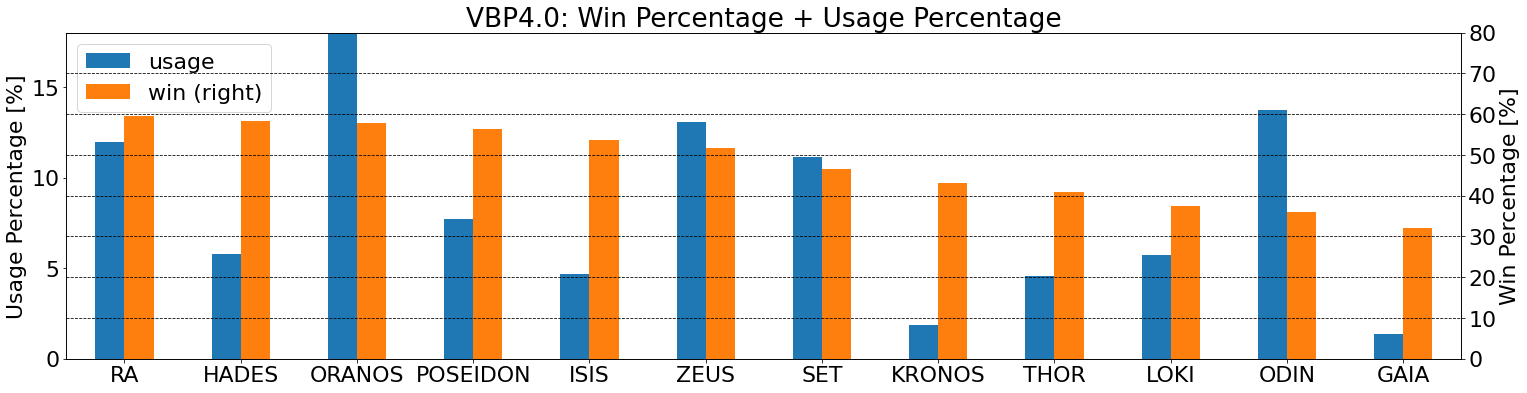

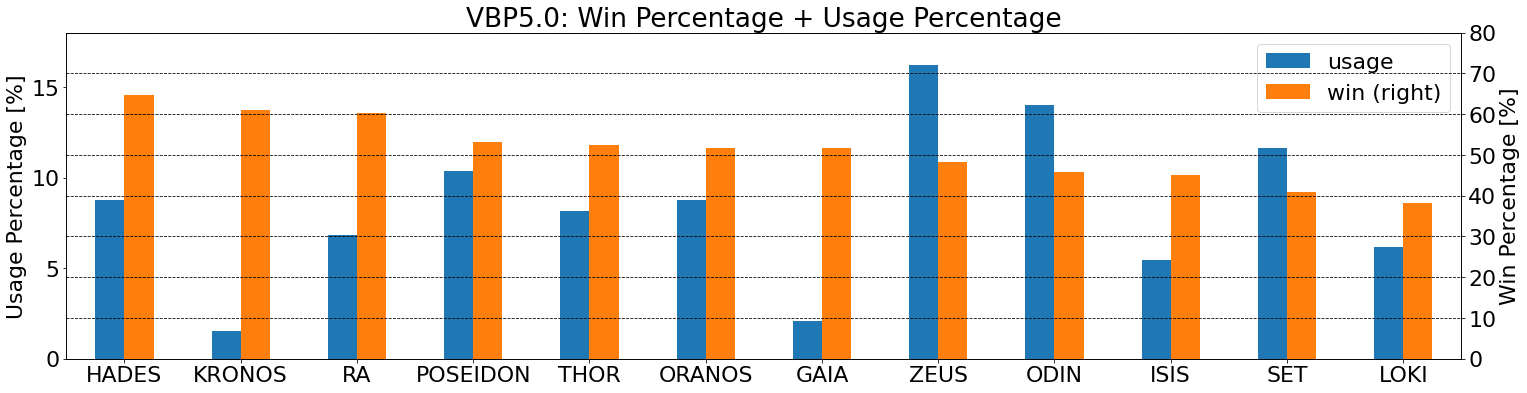

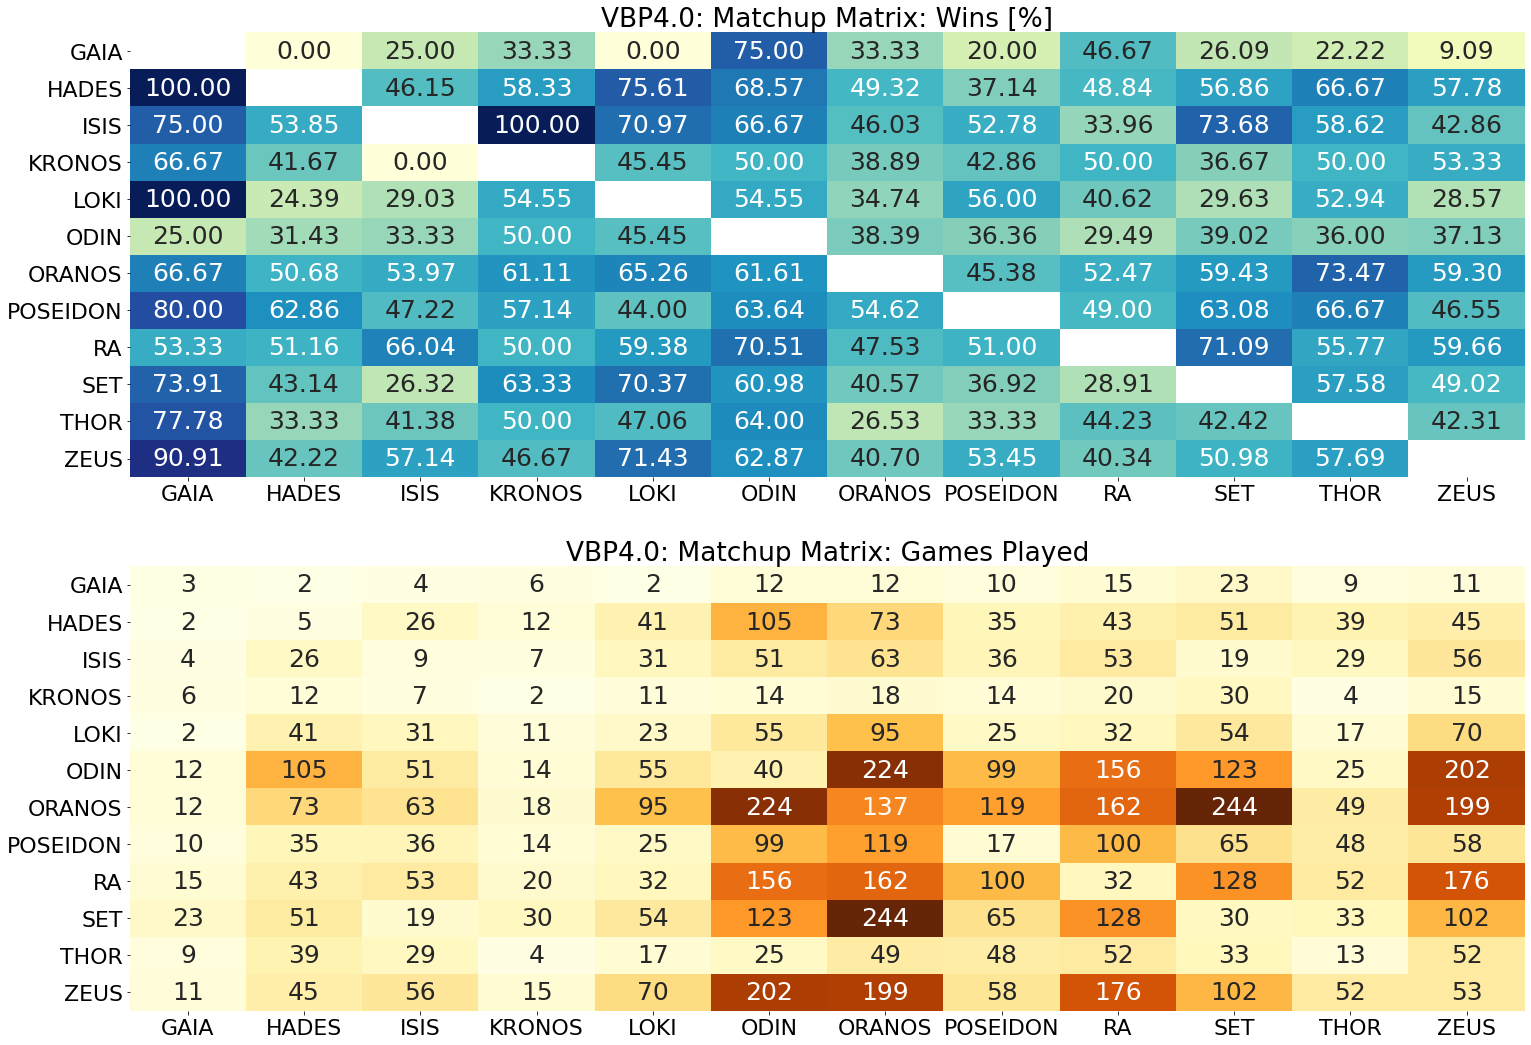

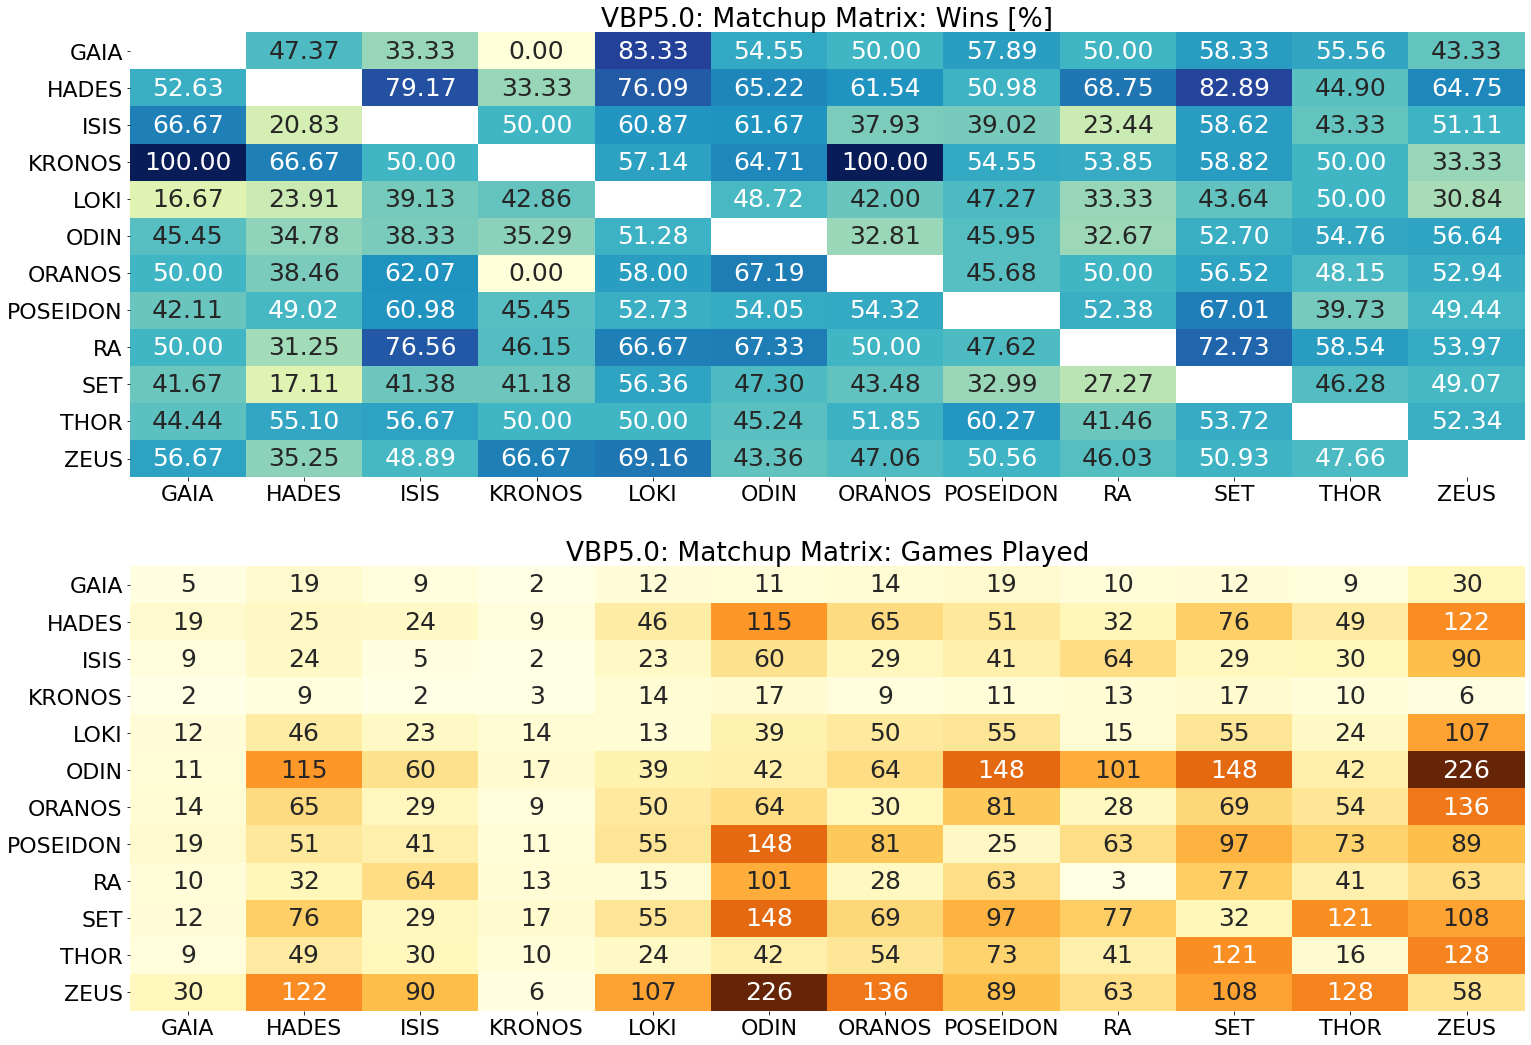

None


In [20]:
today = date.today()
d1 = today.strftime("%d_%m_%Y")
print(d1)
print(os.chdir(path))

# Stats for 1700 rating
folder_string = 'Stats' + d1 + '_1700'
if not os.path.exists(path + '/' + folder_string):
    os.mkdir(path + '/' + folder_string)

os.chdir(path + '/' + folder_string)
print(os.getcwd())

f = open("Meta-Information.txt", "w+")
f.write("Stats for Match Ratings of 1700 and above." + "\n")
f.write("All the stats except the ones that are for specific maps are based on all matches regardless whether or not the map information was still available at the time of scraping." + "\n")
        

#compare_vbp4_vbp5_win_usage(match_frame, player_frame, names = ['zodiac_','__Kimo'])
compare_vbp4_vbp5_win_usage(match_frame, player_frame, rating = 1700, delta = [1,40, 39, 38], logfile = f)

#get_plot_win_usage_perc_maps(match_frame, player_frame, names = ['zodiac_','__Kimo'])
get_plot_win_usage_perc_maps(match_frame, player_frame, rating = 1700, delta = [1, 40, 39, 38], logfile = f)

#ladderstat_analysis_vbp4_vbp5(match_frame, player_frame, rating = 1700, delta = [1, 40, 39, 38], game_duration = 0, names = ['zodiac_','__Kimo'])
ladderstat_analysis_vbp4_vbp5(match_frame, player_frame, rating = 1700, delta = [1, 40, 39, 38], game_duration = 0, logfile =f)


print(os.chdir(path))
f.close()

#Stats for 1800 rating
print(os.getcwd())
folder_string = 'Stats' + d1 + '_1800'

if not os.path.exists(path + '/' + folder_string):
    os.mkdir(path + '/' + folder_string)

os.chdir(path + '/' + folder_string)
print(os.getcwd())

f = open("Meta-Information.txt", "w+")
f.write("Stats for Match Ratings of 1800 and above." + "\n")
f.write("All the stats except the ones that are for specific maps are based on all matches regardless whether or not the map information was still available at the time of scraping." + "\n")


#compare_vbp4_vbp5_win_usage(match_frame, player_frame, names = ['zodiac_','__Kimo'])
compare_vbp4_vbp5_win_usage(match_frame, player_frame, rating = 1800, delta = [1,40, 39, 38], logfile = f)

#get_plot_win_usage_perc_maps(match_frame, player_frame, names = ['zodiac_','__Kimo'])
get_plot_win_usage_perc_maps(match_frame, player_frame, rating = 1800, delta = [1, 40, 39, 38], logfile = f)

#ladderstat_analysis_vbp4_vbp5(match_frame, player_frame, rating = 1700, delta = [1, 40, 39, 38], game_duration = 0, names = ['zodiac_','__Kimo'])
ladderstat_analysis_vbp4_vbp5(match_frame, player_frame, rating = 1800, delta = [1, 40, 39, 38], game_duration = 0, logfile = f)

print(os.chdir(path))
f.close()